# Tutorial - set point optimization

## Introduction
Set-point optimization is the most widely used Optimus use case that helps clients to maximize their plant production by providing optimal set-points in real-time for machines in their plants. 

In this tutorial we will illustrate the typical workflow of the use case, and the steps necessary to successfully run set-point optimization use case. Each step needs to executed sequentially to run this notebook. Targeted audience for this tutorial is data scientists starting Optimus CSTs. The tutorial explains from data preprocessing to optimization while using sample data and tag dictionary, but we expect users to run with their own data and tag dictionary.

## Use case context
Our client is an international iron ore company that operates the end to end supply chain across multiple sites around the globe. One of their biggest losses is the increasing amount of SiO$_2$ (silica) in the concentrate coming out of their flotation plants. Our client asked us to support with constructing a model capable of optimising the operation to reduce the level of SiO$_2$ in concentrate.

<div class="alert alert-info">
<b>Note</b>

In this tutorial, we will be using functions in OptimusAI packages, and we already have tutorial notebooks for each package explaining functions in more detail. We will have a link for users to refer back to the tutorials.
</div>

## Setup

For this tutorial, we need:<br>

1. `input_data`:
    * For this tutorial, we will be using `sample_data.csv`
    * In actual CST, you need to work with DE to collect client data<br><br>

2. Parameters for preprocessing the data and set up controlled variable configuration in recommendation:
    * For this tutorial, we will be using a set of tag config parameters.
    * In actual CST, you need to create your own parameter configurations by following the same format.<br><br>

3. (Only for CRA users) Parameters to assist with the export to CRA:
    * For this tutorial, we will be using meta information.
    * In an actual CST, you need to create your own meta by following the same format.<br><br>
  
4. (Only for CRA users) Results sent to the CRA on previous runs:
    * For this tutorial, we will be using sample results.
    * In an actual CST, you need to use the exports from the previous pipeline run.

In [1]:
# Imports and logging
import logging
import pandas as pd
import sys
logging.basicConfig(level=logging.INFO, stream=sys.stdout)
%matplotlib inline

# use plotly in notebook mode
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

In [2]:
# Adding src dir to env path
from pathlib import Path
sys.path.insert(0, str(Path("../src").resolve()))
# Load the data path
from set_point_optimization.datasets import DATA_DIR

In [3]:
## Load sample data
import set_point_optimization.datasets as datasets
input_data = datasets.get_sample_input_data()
input_data.head()

,date,Sys_A/PLT.ABC_.T0001,Sys_A/PLT.ABC_.T0002,Sys_A/PLT.ABC_.T0003,Sys_A/PLT.ABC_.T0004,Sys_A/PLT.ABC_.T0005,Sys_A/PLT.ABC_.T0006,Sys_A/PLT.ABC_.T0007,Sys_B/PLT.ABC_.T0008,Sys_B/PLT.ABC_.T0009,...,Sys_B/PLT.ABC_.T0015,Sys_B/PLT.ABC_.T0016,Sys_B/PLT.ABC_.T0017,Sys_B/PLT.ABC_.T0018,Sys_B/PLT.ABC_.T0019,Sys_B/PLT.ABC_.T0020,Sys_B/PLT.ABC_.T0021,Sys_A/PLT.ABC_.T0022,Sys_A/PLT.ABC_.T0023,Sys_A/PLT.ABC_.T0024
0,03/10/2017 01:00,55.2,16.98,3162.625026,578.786678,398.753368,10.113487,1.729558,251.166672,250.226086,...,450.383776,446.891845,450.474523,449.912259,455.792161,464.383310,450.532747,66.91,1.31,0
1,03/10/2017 02:00,55.2,16.98,3133.256389,537.219661,399.871822,10.129742,1.667784,249.880589,250.214050,...,449.373361,450.249356,450.081222,450.328806,448.722983,455.501528,451.387700,67.06,1.11,0
2,03/10/2017 03:00,55.2,16.98,3479.482944,591.906744,398.763806,10.048403,1.732711,250.161328,250.104167,...,449.972878,450.868711,450.901822,451.145822,451.134189,459.981311,450.296722,66.97,1.27,0
3,03/10/2017 04:00,55.2,16.98,3228.036436,593.170106,399.866983,9.918614,1.731056,250.208772,250.204761,...,487.940706,491.462111,487.387206,494.528183,495.664011,502.763850,494.939889,66.75,1.36,0
4,03/10/2017 05:00,55.2,16.98,3327.280739,619.710806,399.615089,9.746029,1.765879,249.917800,250.160494,...,549.031539,549.983156,549.459572,549.975483,549.512533,560.696300,550.271772,66.63,1.34,0


---

## Step 1. Preprocessing input data

`preprocessing` package helps users to capture, store, structure and clean data. 

**Important steps for capturing and storing data include**: 

- Rename raw tags with user-friendly names
- Run basic checks on the data (e.g., look for missing variables, missing data, format of date, etc.).
- Perform basic summary stats (min, max, mean, etc.)
- Check summary results with experts

**Important steps for structuring data include**:

- Completeness and quality checks
- Format corrections
- Join data
- Time gridding
- Time shifts (in case time shift is not provided, your can try to use some [data driven estimation methods](konw_document_id=893189))
- Feature engineering (in section dedicated to feature engineering)
- Resample

The output of data structuring is a single flat file with one row per observation

**Important steps for cleaning data include**: 

- Eliminating outliers
- Eliminating redundancies and inconsistencies
- Filling gaps for consistency
- Conducting final quality checks (validation)

The output is cleaned usable data, ready for modelling 

The order of the steps for structuring and cleaning data will be an iterative approach, with several design choices available. 

Please refer to [preprocessing tutorial notebook](../../../../../packages/preprocessing/src/preprocessing/notebooks/preprocessing.ipynb) to understand how each function in `preprocessing` package works in more detail.

Below, we show an example of a standard preprocessing procedure on the input data by using given preprocessing configurations. The preprocessing configurations are sets of parameters to be applied on each tag during the preprocessing steps and need to be aligned with experts iteratively during the data engineering stage. 

### Rename tags by user-friendly names
To make the following analysis easier to read, we first rename the raw tags with some meaningful names. 

In [4]:
from preprocessing.utils import rename_tags
from preprocessing.configs import get_tag_config

# Load the configuration file for renaming the raw tags
tags_raw_config = get_tag_config(
    path_to_tag_config=DATA_DIR / "01_raw/sample_tags_raw_config.csv",
    config_loader="csv",  # Replace with "yaml" if you are using a YAML file
    parameters_schema="raw",  # Replace with the specific schema you need
    delimiter=";",  # Replace with the delimiter used in your configuration file
)

input_data = rename_tags(tags_raw_config=tags_raw_config, data_to_rename=input_data)
input_data.head()

,date,iron_feed,silica_feed,starch_flow,amina_flow,ore_pulp_flow,ore_pulp_ph,ore_pulp_density,air_flow01,air_flow02,...,column_level01,column_level02,column_level03,column_level04,column_level05,column_level06,column_level07,iron_conc,silica_conc,amina_flow_sample_on_off
0,03/10/2017 01:00,55.2,16.98,3162.625026,578.786678,398.753368,10.113487,1.729558,251.166672,250.226086,...,450.383776,446.891845,450.474523,449.912259,455.792161,464.383310,450.532747,66.91,1.31,0
1,03/10/2017 02:00,55.2,16.98,3133.256389,537.219661,399.871822,10.129742,1.667784,249.880589,250.214050,...,449.373361,450.249356,450.081222,450.328806,448.722983,455.501528,451.387700,67.06,1.11,0
2,03/10/2017 03:00,55.2,16.98,3479.482944,591.906744,398.763806,10.048403,1.732711,250.161328,250.104167,...,449.972878,450.868711,450.901822,451.145822,451.134189,459.981311,450.296722,66.97,1.27,0
3,03/10/2017 04:00,55.2,16.98,3228.036436,593.170106,399.866983,9.918614,1.731056,250.208772,250.204761,...,487.940706,491.462111,487.387206,494.528183,495.664011,502.763850,494.939889,66.75,1.36,0
4,03/10/2017 05:00,55.2,16.98,3327.280739,619.710806,399.615089,9.746029,1.765879,249.917800,250.160494,...,549.031539,549.983156,549.459572,549.975483,549.512533,560.696300,550.271772,66.63,1.34,0


### Review input data by creating summary table
We will now create a summary table of input data.  This summary table allows you to: 

- Run basic checks on the data (e.g., look for missing variables, missing data, format of date, etc.) based on meta configuration from data extraction
- Perform basic summary stats (min, max, mean, check for outliers.)
- Check summary results with experts and get feedback

In [5]:
from reporting.rendering.html import plot_table

# Import the create_summary_table function
from preprocessing import create_summary_table
# Load the tag meta configuration file for the summary table
tags_meta_config = get_tag_config(
    path_to_tag_config=DATA_DIR / "01_raw/sample_tags_meta_config.csv",
    config_loader="csv",
    parameters_schema="meta",
    delimiter=";",
)

plot_table(create_summary_table(input_data, tags_meta_config), precision=2)

Above 3% silica the iron ore concentrate produced is downgraded, i.e. it receives a lower sales price than concentrate with silica less than 3%

In [6]:
import reporting

variable_name = "silica_conc"

fig = reporting.charts.primitives.plot_timeline(
    data=input_data,
    x="date",
    y=variable_name,
    title=f"Timeseries plot for {variable_name}"
)
# add 3% limit on plot
fig.add_hline(y=3, line_color="red", line_dash="dash")
fig.show()

### Improve data quality
The following steps 1 to 6 are to improve data quality and ensure the right format of the data.

<div class="alert alert-info">
<b>Note</b>
    
Different clients have different data quality issues, and the below functions will only do basic cleanings so please work with client SMEs to create client specific data cleaning steps.
</div>


In [7]:
# Import cleaning functions
from preprocessing import (
    replace_inf_values,
    remove_null_columns,
    unify_timestamp_col_name,
    round_timestamps,
    enforce_schema,
    deduplicate_pandas,
)

#### 1. Replace infinite values to null

In [8]:
post_replacing_inf_values = replace_inf_values(input_data)

INFO:preprocessing.cleaning:
number of inf values in data: 
           before_cleaning  after_cleaning
iron_feed                3               0


#### 2. Remove columns that are entirely null

In [9]:
post_removing_null = remove_null_columns(post_replacing_inf_values)

INFO:preprocessing.cleaning:All columns have values. Continuing...


#### 3. Rename datetime column to unified timestamp name

The renamed column will be repeatedly used in other functions as well.

In [10]:
post_unify_timestamp_col = unify_timestamp_col_name(
    datetime_col="date",
    data=post_removing_null,
    unified_name="timestamp"
)

INFO:preprocessing.cleaning:Rename column 'date' to 'timestamp'.


#### 4. Round timestamp column to preferred frequency(e.g. 1-min, 10-min, 2-hour)

In [11]:
post_round_timestamp = round_timestamps(
    frequency="2h", 
    data=post_unify_timestamp_col, 
    datetime_col="timestamp"
)

INFO:preprocessing.timezones:Rounding 'timestamp' to '2h' frequency.


#### 5. Remove duplicated rows

In [12]:
post_deduplicate = deduplicate_pandas(data=post_round_timestamp)

INFO:preprocessing.cleaning:Dataframe shape before dedup: (4415, 25)
INFO:preprocessing.cleaning:Dataframe shape after dedup: (4257, 25)
INFO:quality_check_logger:Dropped 158 duplicate timestamps


#### 6. Align data schema specified in `TagDict`
The tag dictionary describes the data type for each tag. To ensure our data frame has the same data type we use the enforce_schema function.

In [13]:
# use data_type from tag dictionary to enforce schema
tag_to_data_type = tags_meta_config.to_df()[["tag_name", "data_type"]]
reporting.rendering.html.plot_table(
    tag_to_data_type,
    show_index=False,
)

In [14]:
post_enforce_schema = enforce_schema(data=post_deduplicate, meta_config=tags_meta_config)

INFO:preprocessing.cleaning:Converting ['air_flow01', 'air_flow02', 'air_flow03', 'air_flow04', 'air_flow05', 'air_flow06', 'air_flow07', 'amina_flow', 'column_level01', 'column_level02', 'column_level03', 'column_level04', 'column_level05', 'column_level06', 'column_level07', 'iron_conc', 'iron_feed', 'ore_pulp_density', 'ore_pulp_flow', 'ore_pulp_ph', 'silica_conc', 'silica_feed', 'starch_flow'] columns to 'numeric' data type.
INFO:preprocessing.cleaning:Converting ['amina_flow_sample_on_off'] columns to 'boolean' data type.


### Remove outliers using provided ranges

Here we assume the outliers are caused by data quality issues rather than change of underlying process (such as unsteady period, change of procedures). For more details on outlier handling, please refer to the `preprocessing` tutorial notebook.

We use expert provided ranges to clean outliers and the ranges can be found in the outlier configuration. There are 2 provided method for outlier handling: 

  - `rule="drop"`: dropping outliers
  - `rule="clip"`: clipping outliers to range_min/range_max

We would prefer using `rule="drop"` in general since clipping can create biased dataset.
  
<div class="alert alert-info">
<b>Note</b>
    
Users should have detailed discussions with SMEs before removing outliers. Some of the sensor values might be seen as outliers from statistic perspective, but they can be meaningful in value.
</div>



In the summary table we saw that the air flows had a significant number of outliers. To understand this, we will first visualize the data.

In [15]:
# Import outlier removal functions
from preprocessing import (
    remove_outlier,
    get_tag_range,
)

variable_name = "air_flow01"

tags_outliers_config = get_tag_config(
    path_to_tag_config=DATA_DIR / "01_raw/sample_tags_outliers_config.csv",
    config_loader="csv",
    parameters_schema="outliers",
    delimiter=";",
)
outlier_range = tags_outliers_config.to_df().set_index("tag_name").loc[variable_name]
range_min, range_max = outlier_range["range_min"], outlier_range["range_min"]

print(f"{variable_name} variable should be between ({range_min}, {range_max})")

fig = reporting.charts.primitives.plot_histogram(
    data=post_enforce_schema,
    x=variable_name,
    title=f"Histogram on {variable_name} before outlier removal",
)

# Add range_min, range_max on the plot
fig.add_vline(x=range_min, line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x=range_max, line_width=3, line_dash="dash", line_color="green")

fig.show()

air_flow01 variable should be between (200.0, 200.0)


To remove the outliers, we can use the `remove_outlier` function by user defined tag range. In this example, the tag range are provided by the tag dictionary, so we can use them directly to remove the outliers.

In [16]:
post_remove_outliers, remove_outliers_summary = remove_outlier(data=post_enforce_schema, outliers_config=tags_outliers_config, rule="drop")
remove_outliers_summary

,tag_name,outlier_percentage
1,iron_feed,4.75
2,silica_feed,5.24
3,starch_flow,21.78
4,amina_flow,6.98
5,ore_pulp_flow,8.46
6,ore_pulp_ph,7.70
7,ore_pulp_density,4.04
8,air_flow01,21.85
9,air_flow02,29.08
10,air_flow03,13.86


In [17]:
print(f"{variable_name} variable should be between ({range_min}, {range_max})")

fig = reporting.charts.primitives.plot_histogram(
    data=post_remove_outliers,
    x=variable_name,
    title=f"Histogram on {variable_name} after outlier removal",
)

# Add range_min, range_max on the plot
fig.add_vline(x=range_min, line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x=range_max, line_width=3, line_dash="dash", line_color="green")

fig.show()

air_flow01 variable should be between (200.0, 200.0)


Sometimes, the tag ranges may not be given, or the given tag ranges may not be useful on the real data. In these situations, we can also get a data driven tag range by using the `calculate_tag_range` function. Below we show how to use this method to calculate a tag range that is based on the [**IQR**](https://en.wikipedia.org/wiki/Interquartile_range). For other methods, please refer to the [API docs](https://brix.quantumblack.com/products/optimus/docs/docs/build/apidoc/preprocessing/preprocessing.html#preprocessing.utils.get_tag_range) of this function.

In [18]:
from preprocessing import calculate_tag_range

tag_ranges = calculate_tag_range(
    data=post_enforce_schema,
    method="IQR",
    list_of_tags=["iron_conc", "silica_conc", "ore_pulp_ph"],
    within_observed_range=True
)
tag_ranges

{'iron_conc': (62.13500000000001, 68.01),
 'silica_conc': (0.17, 4.6899999999999995),
 'ore_pulp_ph': (8.806027247500001, 10.7656296995)}

With this calculated ranges, we can update the outlier configuration by using `update_tag_range`.

In [19]:
from preprocessing import update_tag_range

outliers_data = update_tag_range(tags_outliers_config=tags_outliers_config,
                                 tag_range=tag_ranges)
post_remove_outliers_IQR, remove_outliers_summary = remove_outlier(data=post_enforce_schema, outliers_config=tags_outliers_config, rule="drop")
remove_outliers_summary

,tag_name,outlier_percentage
1,iron_feed,4.75
2,silica_feed,5.24
3,starch_flow,21.78
4,amina_flow,6.98
5,ore_pulp_flow,8.46
6,ore_pulp_ph,5.40
7,ore_pulp_density,4.04
8,air_flow01,21.85
9,air_flow02,29.08
10,air_flow03,13.86


We may still have missing data in our table. There are multiple ways to deal with missing data which include:

- Listwise deletion - Exclude observations with missing data and analyze remainder – can cause bias
- Mean/median imputation - The missing values are replaced by the mean
of the observed, use median to avoid distortions from outliers
- Mode imputation - For categorical data, the mode is used for the imputation
- Forward/linear interpolation, forward: Use the last available measurement; Linear: Interpolate linearly between last and next available data point
- Regression interpolation - Estimate missing values from other strongly correlated inputs

We can see that `silica_feed` still has several nulls

In [20]:
variable_name = "air_flow05"
n_null = post_remove_outliers[variable_name].isnull().sum()
print(f"{variable_name} variable has {n_null} missing values")

air_flow05 variable has 1671 missing values


In [21]:
reporting.charts.primitives.plot_timeline(
    data=post_remove_outliers,
    x="timestamp",
    y=variable_name,
    title=f"Timeseries plot for {variable_name}"
).show()

### Interpolate columns to impute missing values
Users can also use `pandas.DataFrame.fillna()` [(link)](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html) method to do basic null value treatments.

Here, we are imputing missing values by using linear interpolation.

<div class="alert alert-info">
<b>Note</b>
    
Before imputing missing values, please consider risks in creating synthetic data. 
</div>

In [22]:
from preprocessing import interpolate_cols

# Load the imputation configuration file
imputation_config = get_tag_config(
    path_to_tag_config=DATA_DIR / "01_raw/sample_tags_imputation_config.csv",
    config_loader="csv",
    parameters_schema="impute",
    delimiter=";",
)

# We have `limit=3` meaning we only run interpolation 
# when missing values don't exceed more than 3 consecutive units
post_interpolate, missing_data_summary = interpolate_cols(
    data=post_remove_outliers.copy(), 
    impute_config=imputation_config, 
    limit=3,
)

n_null = post_interpolate[variable_name].isnull().sum()
print(f"{variable_name} variable has {n_null} missing values")

INFO:preprocessing.imputing:Interpolating 'iron_feed' column using 'linear' method.
INFO:preprocessing.imputing:Interpolating 'silica_feed' column using 'linear' method.
INFO:preprocessing.imputing:Interpolating 'starch_flow' column using 'linear' method.
INFO:preprocessing.imputing:Interpolating 'amina_flow' column using 'linear' method.
INFO:preprocessing.imputing:Interpolating 'ore_pulp_flow' column using 'linear' method.
INFO:preprocessing.imputing:Interpolating 'ore_pulp_ph' column using 'linear' method.
INFO:preprocessing.imputing:Interpolating 'ore_pulp_density' column using 'linear' method.
INFO:preprocessing.imputing:Interpolating 'air_flow01' column using 'linear' method.
INFO:preprocessing.imputing:Interpolating 'air_flow02' column using 'linear' method.
INFO:preprocessing.imputing:Interpolating 'air_flow03' column using 'linear' method.
INFO:preprocessing.imputing:Interpolating 'air_flow04' column using 'linear' method.
INFO:preprocessing.imputing:Interpolating 'air_flow05'

In [23]:
reporting.charts.primitives.plot_timeline(
    data=post_interpolate,
    x="timestamp",
    y=variable_name,
    title=f"Timeseries plot for {variable_name}"
).show()

### Replace values to null when corresponding on_off_tags are off(if any).


Sometimes you will have data which indicates a piece of equipment is on or off. Here we demonstrate how to clean the related tags for equipment by setting them to 0 when the equipment is off. An example of this is when the power of a pump is off however some flow is still detected by a flow meter. This flow data can be cleaned by setting all related tags when the pump is off to 0.

In [24]:
from preprocessing import set_off_equipment_to_zero

tags_dep_config = get_tag_config(
    path_to_tag_config=DATA_DIR / "01_raw/sample_tags_on_off_dependencies_config.csv",
    config_loader="csv",
    parameters_schema="on_off",
    delimiter=";",
)

post_set_off_equipment = set_off_equipment_to_zero(data=post_interpolate, meta_config=tags_meta_config, on_off_dep_config=tags_dep_config)

INFO:preprocessing.on_off_logic:Setting '{'amina_flow'}' to zero when 'amina_flow_sample_on_off' is off.


### Resample data to match with a unit of analysis for model input

In this example, we want to set our data sampling for modelling to every 3hrs. To do this we resample our data to use the mean value of the data over 3 hrs.

In [25]:
from preprocessing import  resample_data

# Load the resampling configuration file
resample_config = get_tag_config(
    path_to_tag_config=DATA_DIR / "01_raw/sample_tags_resample_config.csv",
    config_loader="csv",
    parameters_schema="resample",
    delimiter=";",
)

resampled_data = resample_data(
    data=post_set_off_equipment, 
    resample_config=resample_config,
    timestamp_col="timestamp",
    errors="coerce",
)

In [26]:
variable_name = "silica_conc"

fig = reporting.charts.primitives.plot_timeline(
    data=post_set_off_equipment.reset_index(),
    x="timestamp",
    y=variable_name,
    title=f"Timeseries plot for {variable_name} before resampling"
)

# add 3% limit on plot
fig.add_hline(y=3, line_color="red", line_dash="dash")
fig.show()

In [27]:
variable_name = "silica_conc"

fig=reporting.charts.primitives.plot_timeline(
    data=resampled_data,
    x="timestamp",
    y=variable_name,
    title=f"Timeseries plot for {variable_name} after resampling"
)

# add 3% limit on plot
fig.add_hline(y=3, line_color="red", line_dash="dash")
fig.show()

### Review summary table on resampled data

In [28]:
reporting.rendering.html.plot_table(
    create_summary_table(resampled_data, tags_meta_config),
    precision=2,
)

Finally, we can output all the preprocessing parameters used above into a single source of truth as below.

In [29]:
from preprocessing import preprocessing_output_summary
df_tag_config = preprocessing_output_summary(
        tags_raw_config,
        tags_meta_config,
        tags_outliers_config,
        imputation_config,
        tags_dep_config,
        resample_config,
        remove_outliers_summary,
        missing_data_summary,
)
df_tag_config.head()

,tag_name,raw_tag,description,display_name,data_source,data_type,tag_type,unit,min,max,...,special_values,outlier_rules,imputation_rule,on_off_dependencies,resample_method,resample_freq,resample_offset,outlier_percentage,missing_count,missing_percentage
0,iron_feed,Sys_A/PLT.ABC_.T0001,percentage of Iron in feed,% Iron Feed,Sys_A,DataType.NUMERIC,TagType.INPUT,%,45.0,65.0,...,9999.0,OutliersRule.DROP,ImputationRule.LINEAR,[],ResampleMethod.MEAN,3H,2H,4.75,202,4.745126
1,silica_feed,Sys_A/PLT.ABC_.T0002,percentage of silica in feed,% Silica Feed,Sys_A,DataType.NUMERIC,TagType.INPUT,%,2.0,30.0,...,None,OutliersRule.DROP,ImputationRule.LINEAR,[],ResampleMethod.MEAN,3H,2H,5.24,223,5.238431
2,starch_flow,Sys_A/PLT.ABC_.T0003,Starch Flow meter,Starch Flow,Sys_A,DataType.NUMERIC,TagType.INPUT,cc/min,2000.0,6000.0,...,-inf,OutliersRule.DROP,ImputationRule.LINEAR,[],ResampleMethod.MEAN,3H,2H,21.78,927,21.775899
3,amina_flow,Sys_A/PLT.ABC_.T0004,Amina Flow meter,Amina Flow,Sys_A,DataType.NUMERIC,TagType.INPUT,cc/min,300.0,700.0,...,None,OutliersRule.DROP,ImputationRule.LINEAR,[amina_flow_sample_on_off],ResampleMethod.MEAN,3H,2H,6.98,297,6.976744
4,ore_pulp_flow,Sys_A/PLT.ABC_.T0005,Ore Pulp Flow meter,Ore Pulp Flow,Sys_A,DataType.NUMERIC,TagType.INPUT,cc/min,370.0,410.0,...,None,OutliersRule.DROP,ImputationRule.LINEAR,[],ResampleMethod.MEAN,3H,2H,8.46,360,8.456660


---

## Step 2: Create engineered features

We have now cleaned our data and discussed the results with the SME. We believe that the combined airflows will have a significant impact on the SiO2 concentration.  In this step we will create an engineered feature to enable us to model the impact of total airflow on SiO2 concentration.   

In general, feature engineering creates new variables from the existing ones to improve model performance. Collaborate with McKinsey and client experts to develop engineering features that capture first principle and improve model performance without introducing co-linearity.

`feature_factory` package helps users to generate engineered feature using raw data. In the package, we have `create_features` function which will start from identifying dependencies for each feature and generate engineered features sequentially. 
  
Please refer to [feature_factory tutorial notebook](../../../../../packages/feature_factory/src/feature_factory/notebooks/feature_factory.ipynb) to understand how each function in `feature_factory` package works in detail.

<div class="alert alert-warning">
<b>Important</b>
    
Newly engineered features need to be manually added in tag dictionary
</div>

<div class="alert alert-info">
<b>Note</b>

Feature name should represent very clear and **human-readable phisical property, not a tag identifier**. This becomes important when feature names are rendered in the [modeling_overview report](../../../../../packages/modeling/src/modeling/notebooks/performance_report.ipynb)


Learn more about feature creation in the [feature_factory tutorial notebook](../../../../../packages/feature_factory/src/feature_factory/notebooks/feature_factory.ipynb)
</div>

In [30]:
# import functions from feature_factory package
from feature_factory import FeatureFactory, draw_graph
import matplotlib.pyplot as plt

### Create `new_features` to define names of new features, dependencies, and functions

In [31]:
new_features = {
    "total_air_flow": {
        "dependencies": [
            "air_flow01",
            "air_flow02",
            "air_flow03",
            "air_flow04",
            "air_flow05",
            "air_flow06",
            "air_flow07",            
        ],
        "function": "feature_factory.sample_function.pandas_sum"
    },
    "total_column_level": {
        "dependencies": [
            "column_level01",
            "column_level02",
            "column_level03",
            "column_level04",
            "column_level05",
            "column_level06",
            "column_level07",            
        ],
        "function": "feature_factory.sample_function.pandas_sum"
    },
    "iron_minus_silica": {
        "dependencies": ["iron_feed", "silica_feed"],
        "function": "feature_factory.sample_function.pandas_subtract"
    },
    "feed_diff_divide_silica": {
        "dependencies": ["iron_minus_silica", "silica_feed"],
        "function": "feature_factory.sample_function.pandas_divide"
    },
    "amina_to_iron_feed": {
        "dependencies": ["amina_flow", "iron_feed"],
        "function": "feature_factory.sample_function.pandas_divide"
    }
}

### Construct feature transformer using `new_features`

In [32]:
feature_factory = FeatureFactory(new_features)

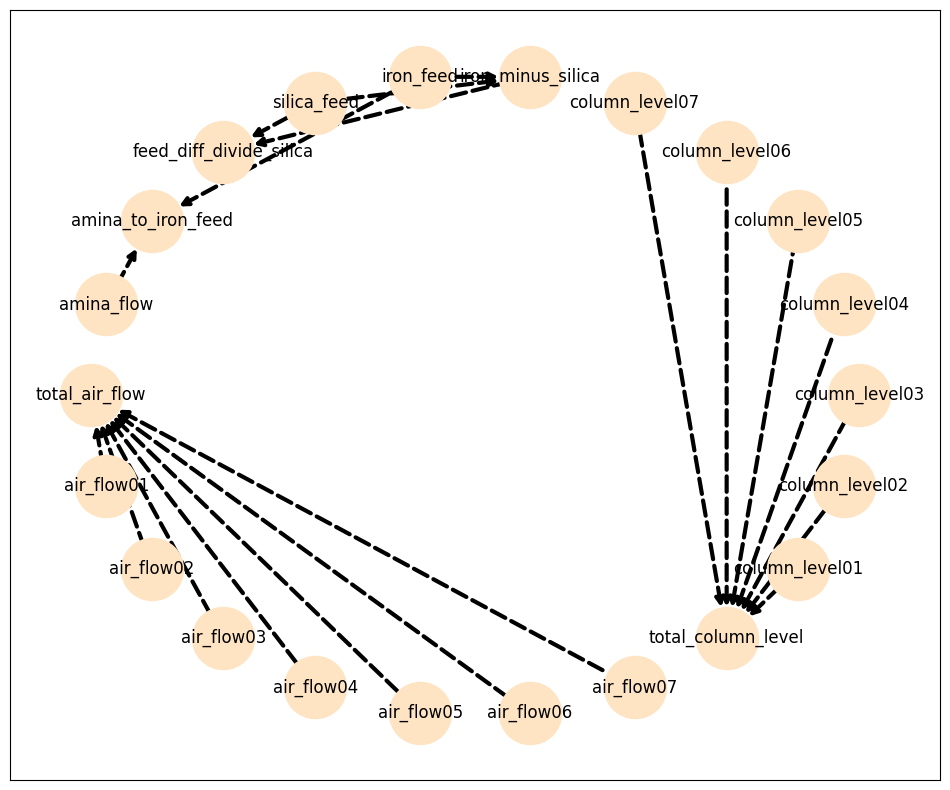

In [33]:
# The plot represents DAGs between engineered features and dependencies
plt.figure(figsize=(12,10))
# plot for the entire dependencies
draw_graph(feature_factory)

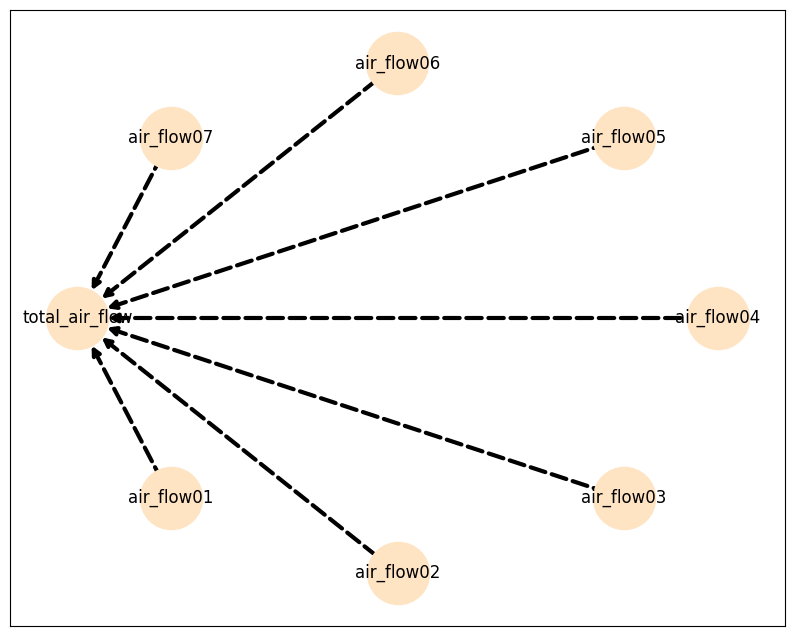

In [34]:
plt.figure(figsize=(10, 8))
# plot for single feature
draw_graph(feature_factory, feature="total_air_flow")

### Create engineered features using `feature_factory` by using `fit_transform` method

In [35]:
model_input = feature_factory.fit_transform(resampled_data)

## Step 3. Explore data

Before modeling the data, let's create the feature reports, keep track of the insights, invest enough time in visual inspection. If the data changes make sure you have the reports ready. Most of the insights from the study will come from this step.


### Define target and specify features
We want to identify the drivers for silica concentration. You can modify which features should be considered in the model. Make sure newly engineered features are also listed.  Also, adding a lagged target variable can improve model performance(if necessary).

<div class="alert alert-info">
<b>Note</b>
    
Make sure to put enough considerations before adding the lagged target variable as a feature.  Lagged target variable will explain most of the variability on target variable which will reduce sensitivities on other variables.
</div>

In [36]:
target_column = "silica_conc"

features = [
    "iron_feed", 
    "silica_feed", 
    "starch_flow",
    "amina_flow",
    "ore_pulp_flow",
    "ore_pulp_ph",
    "ore_pulp_density",
    "total_air_flow",
    "total_column_level",
    "feed_diff_divide_silica",
    "silica_conc_lagged",
]

# add lagged target variable
lagged_target_column = target_column + "_lagged"
model_input[lagged_target_column] = model_input[target_column].shift(1)

reporting.charts.primitives.plot_correlation(
    data=model_input,
    columns=[target_column, *features]
)

### Generate Feature overview report against the target 

In [37]:
# This generates overview report for each feature
plot_dict = reporting.reports.plot_feature_overviews(
    data=model_input,
    features=features,
    timestamp="timestamp",
    tag_ranges=get_tag_range(tags_outliers_config),
    target=target_column,
    layout_params={"height": 700, "width": 850},
)

# uncomment to use widget
# reporting.rendering.interactive.create_plot_demonstration_widget(plot_dict)
plot_dict[features[0]]

<div class="alert alert-warning">   
Uncomment code below to run model feature overview rendering
</div>

In [38]:
# Aggregates overview report for each feature and 
# reporting.rendering.generate_html_report(
#     report_structure=plot_dict,
#     render_path=DATA_DIR / "sample_report/feature_overview.html",
#     report_meta_data={
#         "title": "Silica Concentration Model Feature Overview",
#     },
# )

---

## Step 4: Train model
Working side-by-side with the client’s process experts, you have now structured, cleaned and explored the process data. After analyzing a first set of hypotheses, the plant manager would like to get more insights into what is driving the variability in performance. Time to start modeling!

The main steps for developing a model include:

- Split data in train, test and validation set
- Select features and develop an initial model 
- Evaluate and challenge model performance, discuss resulting insights
- Problem-solve potential model improvements and start the next iteration

The steps we will take to develop the model are:

1.	Define target and specify features 
2.	Drop rows with missing data for the target and feature set 
3.	Split data 
4.	Initialize model 
5.	Tune model hyperparameter
6.	Train model
7.	Evaluate model
8.	Extract feature importance from the model 
9.	Generate visualization to understand the model 

Please refer to [modeling tutorial notebook](../../../../../packages/modeling/src/modeling/notebooks/modeling.ipynb) to understand how each function in `modeling` package works in detail, [model base class](../../../../../packages/modeling/src/modeling/notebooks/model_base.ipynb)  tutorial to understand how model base class works

In [39]:
# import functions from modeling and reporting packages
from modeling import (
    SklearnPipelineTuner,
    create_splitter,
    split_data,
    create_tuner,
    tune_model,
    train_model,
    calculate_model_predictions,
    calculate_metrics,
    calculate_feature_importance,
    calculate_shap_feature_importance,
    cross_validate,
)

### Drop rows with missing data for the target and feature set

As a final check before feeding our data to the modeling algorithm, we remove any rows that contain missing data

In [40]:
model_input_no_nans = model_input.dropna(subset=["timestamp", target_column]+features)

### Split data
Various methods exist for splitting data into train and test sets

  - Out of time sampling (recommended) 
  - Random sampling (only works well for stationary time series)

`modeling` package contains different train/test split classes, so please refer to our [modeling tutorial notebook](../../../../../packages/modeling/src/modeling/notebooks/modeling.ipynb)

In [41]:
# In this example we will use out-of-time sampling, specifying a specific split date
splitter = create_splitter(
    split_method="date",
    splitting_parameters={
        "datetime_column": "timestamp",
        "split_datetime": "2017-08-30 23:00:00",
    },
)

train_data, test_data = splitter.split(model_input_no_nans)

INFO:modeling.splitters._splitters.base_splitter:Length of data before splitting is 1245
INFO:modeling.splitters._splitters.by_date_splitter:Splitting by datetime: 2017-08-30 23:00:00
INFO:modeling.splitters._splitters.base_splitter:Length of the train data after splitting is 1174, length of the test data after splitting is 71.


### Initialize model

Next we can initialize our model. This model should be an instance of `ModelBase`[(link)](../../../../../../../html/docs/build/apidoc/optimus_core/optimus_core.model_base.html#optimus_core.model_base.models.ModelBase). In this tutorial we will build a `SklearnPipeline`[(link)](../../../../../../../html/docs/build/apidoc/optimus_core/optimus_core.model_base.html#optimus_core.model_base.models.SklearnPipeline), which is a wrapper for `sklearn.pipeline.Pipeline`.

We can also pass more transformer steps such as a standard scaler. Note that we use the utility class `SklearnTransform`[(link)](../../../../../packages/optimus_core/src/optimus_core/transformer/README.md).

The [modeling tutorial notebook](../../../../../packages/modeling/src/modeling/notebooks/modeling.ipynb) provides further details on model initialization and specifications.

In [42]:
from modeling import SklearnPipelineFactory


sklearn_pipeline_init_config = {
    "estimator": {
        "class_name": "sklearn.linear_model.SGDRegressor",
        "kwargs": {
            "random_state": 123,
            "penalty": "elasticnet"
        }
    },
    "transformers": [{
        "class_name": "sklearn.preprocessing.StandardScaler",
        "kwargs": {},
        "name": "standard_scaler",
        "wrapper": "preserve_columns",
    }
    ]
}

sklearn_pipeline_factory = SklearnPipelineFactory(
    model_init_config=sklearn_pipeline_init_config,
    features_in=features,
    target=target_column,
)

sklearn_pipeline = sklearn_pipeline_factory.create()
sklearn_pipeline

SklearnPipeline(estimator=Pipeline(steps=[('standard_scaler',
                 SklearnTransform(transformer=StandardScaler())),
                ('estimator',
                 SGDRegressor(penalty='elasticnet', random_state=123))]), target="silica_conc" ,features_in=['iron_feed', 'silica_feed', 'starch_flow', 'amina_flow', 'ore_pulp_flow', 'ore_pulp_ph', 'ore_pulp_density', 'total_air_flow', 'total_column_level', 'feed_diff_divide_silica', 'silica_conc_lagged'], features_out=None)

### Tune model hyperparameters

This is an optional step which produces a `BaseModel` instance with its' hyperparameter tuned.
The hyperparameter to specify depend on the selected estimator class:

  - [GridSearchCV docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
  - [Sklearn scoring docs](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
  - [Sklearn metrics docs](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

In [43]:
sklearn_pipeline_tuner_config = {
    'class_name': 'sklearn.model_selection.GridSearchCV',
    'kwargs': {
        'n_jobs': -1,
        'refit': 'mae',
        'param_grid': {
            'estimator__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
            'estimator__l1_ratio': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
            'estimator__n_iter_no_change': [5, 10, 20],

        },
        'scoring': {
            'mae': 'neg_mean_absolute_error',
            'rmse': 'neg_root_mean_squared_error',
            'r2': 'r2',
        }
    }
}

In [44]:
print("Initial params:\n")
for k, v in sklearn_pipeline.estimator.get_params().items():
    print(f"{k}: {v}")

Initial params:

alpha: 0.0001
average: False
early_stopping: False
epsilon: 0.1
eta0: 0.01
fit_intercept: True
l1_ratio: 0.15
learning_rate: invscaling
loss: squared_error
max_iter: 1000
n_iter_no_change: 5
penalty: elasticnet
power_t: 0.25
random_state: 123
shuffle: True
tol: 0.001
validation_fraction: 0.1
verbose: 0
warm_start: False


In [45]:
sklearn_pipeline_tuner = create_tuner(
    model_factory=sklearn_pipeline_factory,
    model_tuner_type=SklearnPipelineTuner,
    tuner_config=sklearn_pipeline_tuner_config,
)

sklearn_pipeline = tune_model(
    model_tuner=sklearn_pipeline_tuner,
    data=train_data,
    hyperparameters_config=None,
)

print("The best params:\n")
for k, v in sklearn_pipeline.estimator.get_params().items():
    print(f"{k}: {v}")

INFO:modeling.models.sklearn_pipeline.model:`features_out` attribute is not specified. Setting `features_out` based on factual data.
INFO:modeling.models.sklearn_pipeline.tuner:Initializing sklearn hyperparameters tuner...
INFO:modeling.models.sklearn_pipeline.tuner:Tuning hyperparameters...
The best params:

alpha: 0.0001
average: False
early_stopping: False
epsilon: 0.1
eta0: 0.01
fit_intercept: True
l1_ratio: 1e-05
learning_rate: invscaling
loss: squared_error
max_iter: 1000
n_iter_no_change: 20
penalty: elasticnet
power_t: 0.25
random_state: 123
shuffle: True
tol: 0.001
validation_fraction: 0.1
verbose: 0
warm_start: False


### Train model

The model can now be fit to our training dataset

In [46]:
trained_sklearn_pipeline = train_model(sklearn_pipeline, train_data)

### Generate visualizations to understand data and model

You are excited to present your modeling results to the process experts. Upfront to your PS session, you’d like to share a summary of the model and its performance.

In [47]:
from modeling.report import get_modeling_overview

model_performance_figures = get_modeling_overview(
    model=trained_sklearn_pipeline,
    timestamp_column="timestamp",
    train_data=train_data,
    test_data=test_data,
)

INFO:modeling.models.sklearn_pipeline.model:`Using model-agnostic` <class 'shap.explainers._permutation.PermutationExplainer'>` to extract SHAP values... `shap` can't apply model-specific algorithms for <class 'modeling.models.sklearn_pipeline.model.SklearnPipeline'>. Consider switching to `SklearnModel` if computation time or quality don't fit your needs.


PermutationExplainer explainer: 1175it [01:02, 15.88it/s]                          


INFO:modeling.models.sklearn_pipeline.model:Estimator of type <class 'sklearn.linear_model._stochastic_gradient.SGDRegressor'> does not have `feature_importances_` using sklearn.inspection.permutation_importances instead.


Degrees of freedom <= 0 for slice
invalid value encountered in divide
invalid value encountered in double_scalars


<div class="alert alert-warning">   
Uncomment code below to run model performance report rendering
</div>

In [48]:
# reporting.rendering.generate_html_report(
#     report_structure=model_performance_figures,
#     render_path=PATH_TO_DATA_DIR / "sample_report/silica_model_report.html",
#     report_meta_data={
#         "title": "Silica Concentration Model Performance Report",
#     },
# )

### Create model training artifacts

We can now use the trained model to compute predictions, metrics and feature importance in the form of DataFrames to store as model training artifacts. 

Note, these artifacts are not used for creating model performance report.

#### Extract predictions and metrics

In [49]:
train_predictions = calculate_model_predictions(
    train_data, trained_sklearn_pipeline,
)
test_predictions = calculate_model_predictions(
    test_data, trained_sklearn_pipeline,
)

These predictions can now be used to evaluate model performance

In [50]:
train_metrics = calculate_metrics(
    train_data, model=trained_sklearn_pipeline,
)

test_metrics = calculate_metrics(
    test_data, model=trained_sklearn_pipeline,
)

metrics = pd.DataFrame(
    {
        "train_metric_value": train_metrics,
        "test_metric_value": test_metrics,
    },
).rename_axis("metric_name")

metrics

,train_metric_value,test_metric_value
metric_name,,
mae,0.387535,0.315148
rmse,0.513571,0.390547
mse,0.263756,0.152527
mape,0.197867,0.179339
r_squared,0.474549,0.369259
var_score,0.474559,0.435287


`modeling` package also provides functionality to do cross-validation in a single function call: `cross_validate()` is the API you should to use for that.

In [51]:
cv_strategy_config = {
    "class_name": "sklearn.model_selection.TimeSeriesSplit",
    "kwargs": {
        "n_splits": 3,
    },
}

cross_validation_scores = cross_validate(
    model=trained_sklearn_pipeline,
    data=model_input_no_nans,
    cv_strategy_config=cv_strategy_config,
)
cross_validation_scores

INFO:modeling.models._cross_validation:Cross-validating using: TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None)


mae        mape         mse       r_squared        rmse        \
     train  test train  test train  test     train  test train  test   
Fold                                                                   
0     0.48  0.60  0.23  0.38  0.36  0.48      0.39  0.06  0.60  0.69   
1     0.42  0.43  0.21  0.25  0.30  0.28      0.51  0.23  0.55  0.53   
2     0.42  0.31  0.21  0.16  0.29  0.18      0.48  0.37  0.54  0.42   

     var_score        
         train  test  
Fold                  
0         0.39  0.47  
1         0.51  0.29  
2         0.48  0.38

In the example above, we are using a `TimeSeriesSplit` strategy which is usually a good proxy of what accuracy to expect in production.
[Here in the `sklearn` documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#visualize-cross-validation-indices-for-many-cv-objects) you can find visual examples of this and other available strategies.

> Once you validated the model in terms of estimator type, hyperparameters and feature set, before deploying to production, you may want to **re-train it on the entire dataset**.

In case you want to use `MLflow` experiment tracking tool:
* Install it by
  ```bash
  pip install mlflow
  ```
* Uncomment cell below to log metrics and trained model to `MLflow`
* Get acquainted with experiment tracking tutorial provided by modeling package 

In [52]:
# import mlflow
# 
# mlflow.log_metrics(test_metrics)
# mlflow.log_artifact("path-to-your-picked-trained-model")

In [53]:
df_plot_model = pd.DataFrame({
    "timestamp": test_data["timestamp"],
    target_column: test_predictions["model_prediction"],
    "type": "prediction",
})
df_plot_actual = pd.DataFrame({
    "timestamp": test_data["timestamp"],
    target_column: test_data[target_column],
    "type": "actual",

})
df_plot = pd.concat([df_plot_model, df_plot_actual])

In [54]:
reporting.charts.primitives.plot_timeline(
    data=df_plot,
    x="timestamp",
    y=target_column,
    color="type",
    title="Timeseries plot for prediction"
).show()

#### Extract feature importance from model

To understand the relative importance of each feature to the overall model better, we'll calculate  the feature importance scores.

`get_feature_importance()` is mandatory method for all OptimusAI models, and feature importance computation methodology lives on the model side. See [model base](../../../../../packages/modeling/src/modeling/notebooks/model_base.ipynb) tutorial for more details.

Default implementation for `SklearnPipeline` checks for `feature_importance_` property, and if it does not exist uses `sklearn.inspection.permutation_importance`[(link)](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance) instead. 

In [55]:
default_importance = trained_sklearn_pipeline.get_feature_importance(
    train_data,
)
shap_importance = trained_sklearn_pipeline.get_shap_feature_importance(
    train_data[trained_sklearn_pipeline.features_in],
)
importance_table = pd.DataFrame(
    {
        "default_importance": default_importance,
        "shap_importance": shap_importance,
    }
)
reporting.rendering.html.plot_table(
    data=importance_table,
    sort_by=[("shap_importance", "desc")],
    columns_to_color_as_bars=list(importance_table.columns),
)

INFO:modeling.models.sklearn_pipeline.model:Estimator of type <class 'sklearn.linear_model._stochastic_gradient.SGDRegressor'> does not have `feature_importances_` using sklearn.inspection.permutation_importances instead.
INFO:modeling.models.sklearn_pipeline.model:`Using model-agnostic` <class 'shap.explainers._permutation.PermutationExplainer'>` to extract SHAP values... `shap` can't apply model-specific algorithms for <class 'modeling.models.sklearn_pipeline.model.SklearnPipeline'>. Consider switching to `SklearnModel` if computation time or quality don't fit your needs.


PermutationExplainer explainer: 1175it [00:54, 17.41it/s]                          


---

## Step 5: Running optimization

Now that we have a model to predict silica concentration, we can use it to optimize the process performance. There are four main steps to address this set point optimization problem:

1. Create controlled parameters config that holds domain definition for each control
2. Define the problem factory with the objective function and constraints
3. Select solver & stopper for the optimizer algorithm
4. Run the optimization and assess uplift potential and recommendation quality

We will use `recommend` package to conduct optimization. Refer to [recommend tutorial notebook](../../../../../packages/recommend/src/recommend/notebooks/recommend.ipynb) to learn more about the package.

### 1. Define controlled parameters

In [56]:
from recommend import ControlledParametersConfig

control_config =  datasets.get_sample_controlled_parameters_config()
controlled_parameters_config = ControlledParametersConfig(control_config)
controlled_parameters_config

ControlledParametersConfig(
    keys={
        'amina_flow', 'ore_pulp_density', 'ore_pulp_flow', 'ore_pulp_ph',
        'starch_flow', 'total_air_flow', 'total_column_level',
    },
    values=(...),
)

### 2. Define the problem factory with the objective function and constraints

Here, we define problem factory required for optimisation through implementing abstract class `recommend.ProblemFactoryBase`.

Refer to [`recommend` package tutorial]((../../../../../packages/recommend/src/recommend/notebooks/recommend.ipynb)) for more details about `recommend.ProblemFactoryBase`.

#### Define objective function

You can define any objective and how to create one for any row provided via `_create_objective`, note returned objective must comply with `recommend.ObjectiveFunction` protocol. We'll consider silica conc predictor as our objective.

In a study, ensure the objective function:
  - Is directly link it to impact, usually related dollar values
  - Avoids unnecessary complexity to ensure set point optimizer is effective

#### Define constraints

You can define any constraints (penalties or repairs) and define how those are created for any row provided via `_create_penalties` and `_create_repairs`.

In a study this step may include: 
  - Covering operational business logic using penalties/repairs, defining additional soft sensors (model based constraints)
  - Working with SME to identify potential constraints
  - Challenging thresholds using historical data and constraint violation
  - Tuning the penalty weights to match the desired effect on the objective

#### Define the problem factory

In [57]:
import typing as tp
from functools import partial

import pandas as pd

from recommend import ObjectiveFunction, ProblemFactoryBase
from optimizer import Penalty, Repair, penalty
from modeling import ModelBase

class SilicaProblemFactory(ProblemFactoryBase):
    def _create_objective(self, row_to_optimize: pd.DataFrame) -> ObjectiveFunction:
        """
        Returns the objective. It will be used
        to create `optimizer.StatefulOptimizationProblem`.

        Note that the returned function must take only `parameters` as an input
        i.e. all the additional kwargs must be wrapped via `functools.partial`
        before returning the function

        This objective can be either maximized or minimized based on
        the `ProblemFactory.sense` (provided during init).
        """

        return partial(
            calculate_objective,
            silica_conc_model=self._model_registry["silica_conc_model"],
        )


    def _create_penalties(self, row_to_optimize: pd.DataFrame) -> tp.List[Penalty]:
        """Returns penalties. Currently, it includes only flow penalty."""

        flow_penalty = penalty(
            calculate_flow_penalty,
            "<=",
            3600,
            name="starch_and_amina_flow",
            penalty_multiplier=0.0125,
        )
        return [flow_penalty]

    def _create_repairs(self, row_to_optimize: pd.DataFrame) -> tp.List[Repair]:
        """ Creates no repairs """
        return []


def calculate_objective(
    parameters: pd.DataFrame,
    silica_conc_model: ModelBase,
) -> pd.Series:
    """ Returns objective value estimated by silica conc model. """
    return silica_conc_model.predict(parameters)


def calculate_flow_penalty(parameters: pd.DataFrame) -> pd.Series:
    return parameters["starch_flow"] + parameters["amina_flow"]

#### Create instance of problem factory

In [58]:
from optimizer import StatefulOptimizationProblem

problem_factory = SilicaProblemFactory(
    controlled_parameters_config=controlled_parameters_config,
    problem_class=StatefulOptimizationProblem,
    problem_kwargs={"sense": "minimize"},
    model_registry={"silica_conc_model": trained_sklearn_pipeline},
)
problem_factory

SilicaProblemFactory(
    optimized_columns=ControlledParametersConfig(
        keys={
            'amina_flow', 'ore_pulp_density', 'ore_pulp_flow', 'ore_pulp_ph',
            'starch_flow', 'total_air_flow', 'total_column_level',
        },
        values=(...),
    ),
    problem_class=StatefulOptimizationProblem,
    problem_kwargs={'sense': 'minimize'},
    model_registry={
        'silica_conc_model',
    },
)

### 3. Select solver & stopper for the optimizer algorithm

We use `recommend.SolverFactory` to create solver & stopper for each optimized row. 

Refer to [recommend package tutorial]((../../../../../packages/recommend/src/recommend/notebooks/recommend.ipynb)) for more details about `recommend.SolverFactory`.

#### Choose solver to run optimization
`recommend` package uses `optimizer` package as a backend. Hence, we can use any of its solvers, so please refer to [solvers tutorial](../../../../../packages/optimizer/docs/source/04_user_guide/03_solver.md) to pick the one you need for your case.

There are 2 main solver classes: 

- Discrete solver `GridSearchSolver`: Exact, as it explores all possible recommendations. Works effectively only for ‘small’ (10^8) population size
- Continuous meta-heuristic solver `DifferentialEvolutionSolver`: Approximate, explores the solution space quasi-randomly guided by heuristics. Works effectively for larger population sizes.

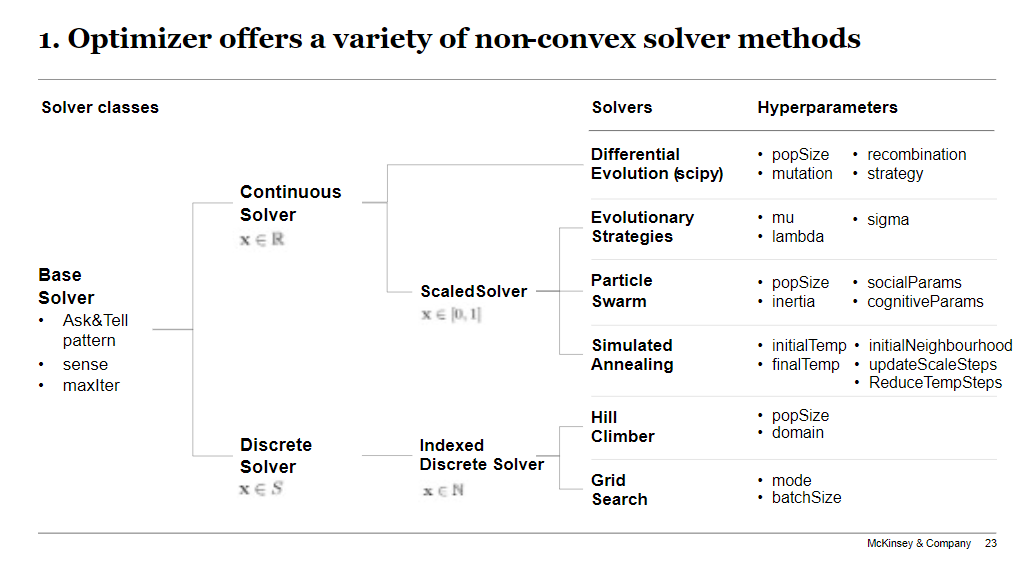

#### Choose stopper to run optimization

`recommend` package uses `optimizer` package as a backend. Hence, we can any of its stoppers, so please refer to [stoppers tutorial](../../../../../packages/optimizer/docs/source/04_user_guide/05_stopper.md) to pick the one you need for your case.

#### Create instance of solver factory

In [59]:
from recommend import SolverFactory
from optimizer.solvers import DifferentialEvolutionSolver
from optimizer.stoppers import NoImprovementStopper

# Sample kwargs for DifferentialEvolutionSolver
solver_kwargs = {
    "sense": "minimize",
    "seed": 0,
    "maxiter": 100,
    "mutation": [0.5, 1.0],
    "recombination": 0.7,
    "strategy": "best1bin",
}

# Sample kwargs for NoImprovementStopper
stopper_kwargs = {
    "patience": 10,
    "sense": "minimize",
    "min_delta": 0.1    
}

solver_factory = SolverFactory(
    controlled_parameters_config=controlled_parameters_config,
    solver_class=DifferentialEvolutionSolver,
    solver_kwargs=solver_kwargs,
    stopper_class=NoImprovementStopper,
    stopper_kwargs=stopper_kwargs,
)
solver_factory

SolverFactory(
    solver_class=DifferentialEvolutionSolver,
    solver_kwargs={
        'sense': 'minimize',
        'seed': 0,
        'maxiter': 100,
        'mutation': [0.5, 1.0],
        'recombination': 0.7,
        'strategy': 'best1bin',
    },
    stopper_class=NoImprovementStopper,
    stopper_kwargs={
        'patience': 10, 'sense': 'minimize', 'min_delta': 0.1,
    },
    domain_generator=BoundedLinearSpaceDomain(
        controlled_parameters=ControlledParametersConfig(
            keys={
                'amina_flow', 'ore_pulp_density', 'ore_pulp_flow', 'ore_pulp_ph',
                'starch_flow', 'total_air_flow', 'total_column_level',
            },
            values=(...),
        ),
    ),
)

### 4. Run the optimization

During this step in order to evaluate the optimization results:
- Check feasibility and quality of optimum recommendations
- Check sensitivity to changes in model parameters and assumptions
- Run statistically significant number of counterfactual shifts to estimate expected uplift 
- Ensure estimated uplift is higher than the model error

In [60]:
from recommend import optimize
from optimizer.loggers import BasicLogger, BestTrajectoryLogger, PenaltyLogger

solutions = optimize(
    test_data,
    problem_factory,
    solver_factory,
    loggers=[BasicLogger(), BestTrajectoryLogger(), PenaltyLogger()],
    n_jobs=-1,
)
solutions

INFO:recommend.optimize._optimize:Creating problem, solver, and stopper for each row


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 out of  71 | elapsed:    4.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:    4.1s finished


Solutions(
    keys=[
        1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1401, 1402, 1403, 1404,
        1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416,
        1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428,
        1429, 1430, 1431, 1432, 1433, 1434, 1435, 1437, 1438, 1439, 1443, 1445,
        1446, 1447, 1449, 1450, 1451, 1452, 1453, 1457, 1458, 1459, 1460, 1461,
        1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472,
    ],
    values=(...),
)

In [61]:
# this is how we can transform solutions in the tabular format
# for further analysis
solutions_frame = solutions.to_frame()
solutions_frame.head()

timestamp  iron_feed silica_feed  starch_flow               \
type             initial    initial     initial      initial    optimized   
1392 2017-08-30 23:00:00  53.246667   18.513333  3199.638567  3004.968215   
1393 2017-08-31 02:00:00      48.46        24.9  2581.807141  3082.132788   
1394 2017-08-31 05:00:00      48.46        24.9  2585.699778  3003.292952   
1395 2017-08-31 08:00:00       54.4       18.52  2866.012968  3072.910853   
1396 2017-08-31 11:00:00       54.4       18.52  3716.986877    3060.7712   

      amina_flow             ore_pulp_flow             ore_pulp_ph  ...  \
type     initial   optimized       initial   optimized     initial  ...   
1392  522.255576   584.29192    379.969373  401.151952    9.060688  ...   
1393   466.51866  511.380855     381.11359   400.58575    9.040131  ...   
1394  467.219217  493.872014    381.388653  400.746285    9.161542  ...   
1395  491.272943  493.229018    380.256426  400.221374    9.404451  ...   
1396   415.15145  510.292384    379.653206  401.146509    9.312112  ...   

     silica_conc_lagged objective           starch_and_amina_flow_penalty  \
type            initial   initial optimized                       initial   
1392              3.854  3.346951  3.215621                      1.523677   
1393              3.225  2.897357  2.792745                           0.0   
1394            2.51625  2.404851  2.336148                           0.0   
1395               1.26  1.668767  1.547142                           0.0   
1396             1.6075  1.795272  1.675115                      6.651729   

               starch_and_amina_flow_slack              \
type optimized                     initial   optimized   
1392       0.0                         NaN   10.739865   
1393       0.0                  551.674199    6.486356   
1394       0.0                  547.081005  102.835033   
1395       0.0                  242.714089   33.860129   
1396       0.0                         NaN   28.936416   

                                    run_id is_successful_optimization  \
type                                                                    
1392  b509e549-d415-4eb3-b17c-004e4b870b5c                       True   
1393  68127733-cdd7-4100-8912-04992fb49344                       True   
1394  3e14227f-0f29-4539-be8e-a1b1cf72cc9c                       True   
1395  5dbe4639-3af9-41dd-a1cc-70cee2ee4a99                       True   
1396  ac5e4475-538e-4a01-8ee5-8f0aee18696b                       True   

        uplift  
type            
1392  -0.13133  
1393 -0.104612  
1394 -0.068703  
1395 -0.121625  
1396 -0.120157  

[5 rows x 47 columns]

#### Run diagnostics

Diagnostics allows understanding the limiting constraints (penalties/value bounds) that can be refined to bring additional value. Learn more about solution diagnostics  functionality in the recommend package [tutorial notebook](../../../../../packages/recommend/src/recommend/notebooks/solution_diagnostics.ipynb).

In [62]:
# we'll pick the first row from the optimized dataset
row_index = test_data.index[0]

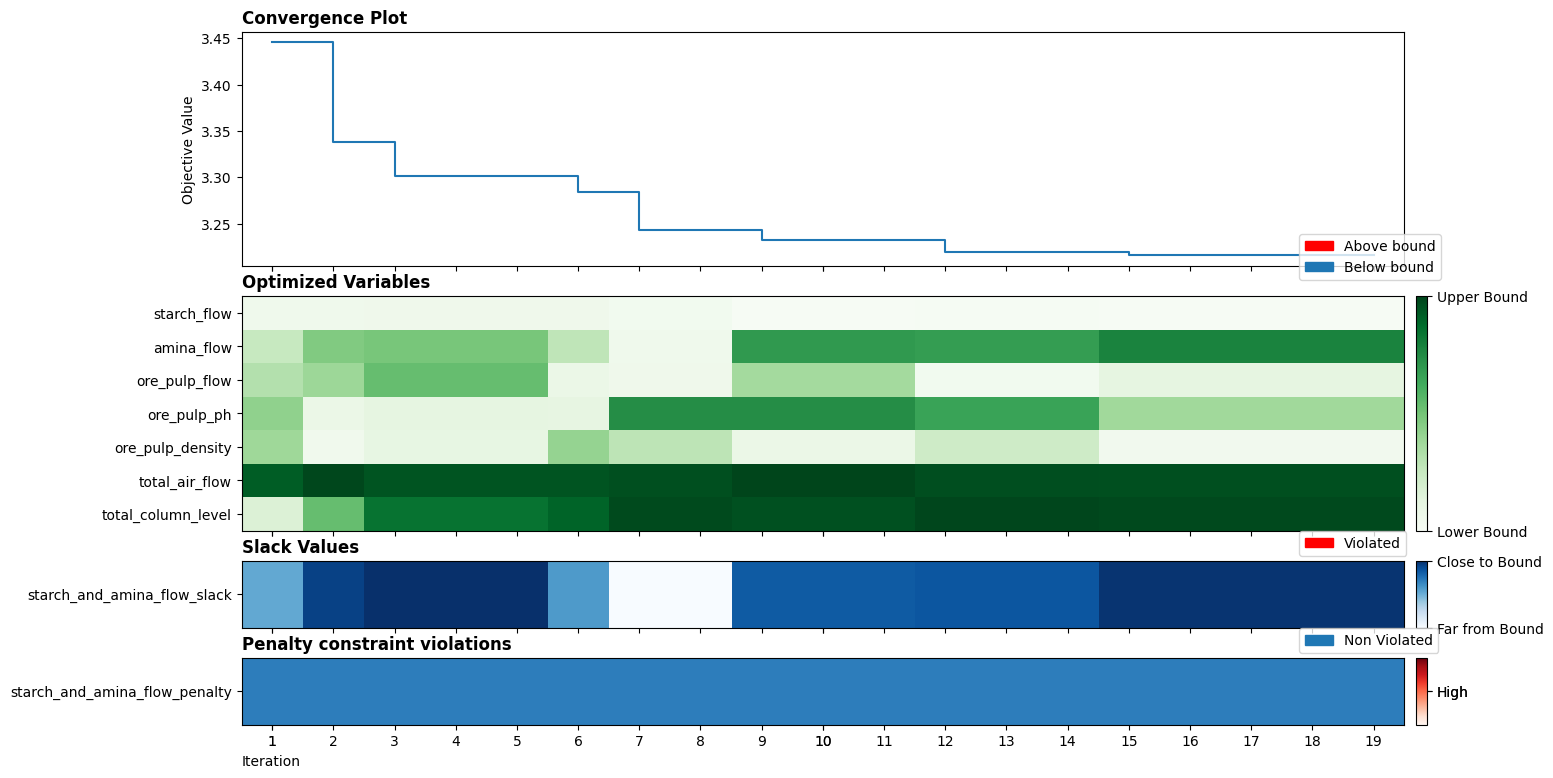

In [63]:
from recommend.solution import plot_best_trajectory_summary

fig = plot_best_trajectory_summary(solutions[row_index])

This best trajectory summary shows us:
1. Objective evolution
2. Controls' domain evolution from which here we can see if our controls reach bound and which one: lower or upper.
3. Slack (additional distance of the `InequalityConstrain` to its bound)
4. Penalty value added to the objective

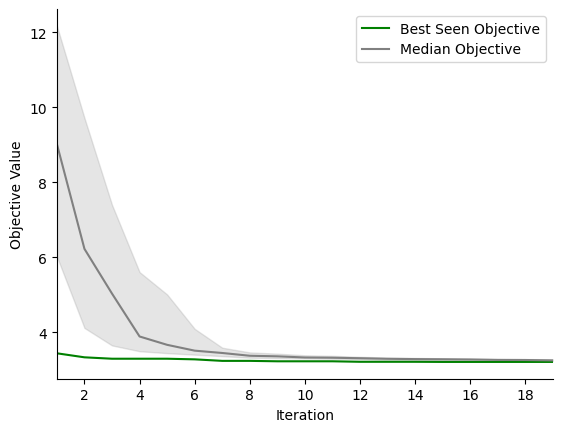

In [64]:
from recommend.solution import plot_convergence_evolution

plot_convergence_evolution(solutions[row_index])

This convergence plot shows us the best seen objective evolution as well as objective's distribution improvement through optimization.

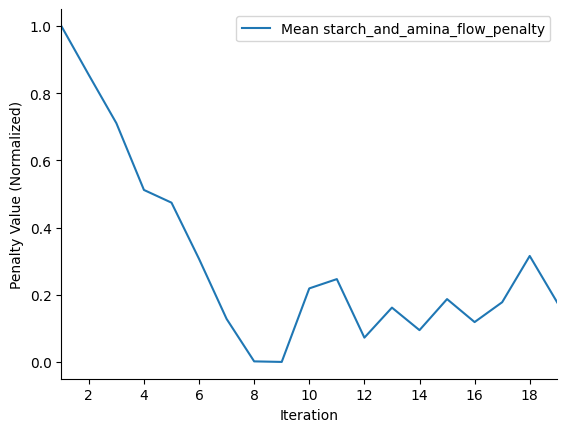

In [65]:
from recommend.solution import plot_penalties

plot_penalties(solutions[row_index])

This penalties plot shows us each penalties' mean value evolution through optimization.

#### Create optimization explainer plot

Optimization explainer allows understanding the logic behind the black-box optimization by comparing the initial and optimized values. Learn more about optimization explainer functionality in the recommend package [tutorial notebook](../../../../../packages/recommend/src/recommend/notebooks/optimization_explainer.ipynb).

Let's see how dependency between optimization objective and "total_air_flow" looks like:

In [66]:
# we'll pick the first row from the optimized dataset
row_index = test_data.index[0]

In [67]:
from recommend import create_optimization_explainer_plot

create_optimization_explainer_plot(
    optimizable_parameter="total_air_flow",
    solution=solutions[row_index],
)

We've introduced penalty for the "amina_flow", let's see how it affected the recommendation:

In [68]:
create_optimization_explainer_plot(
    dependent_function=solutions[row_index].problem.penalties[0],
    optimizable_parameter="amina_flow",
    solution=solutions[row_index],
)

#### Create Counterfactual report

We can generate a comprehensive overview report to compare the optimization solutions and the actual historical values. This usually serves as a good indicator or estimator of the impact if we could have run the optimization and use the recommended value historically. 

For this purpose, we can use `get_solutions_overview` from the `recommend` package (for more details please refer to [this tutorial](../../../../../packages/recommend/src/recommend/notebooks/counterfactual_analysis.ipynb)). This function assembles the solutions from the optimization and historical data into a list of comparison figures.

<div class="alert alert-warning">   
Uncomment code below to generate the figures.
</div>

In [69]:
# from recommend.report import get_solutions_overview

# figs = get_solutions_overview(
#     solutions,
#     actual_target_column="silica_conc",
#     objective_units="%",
#     controls_config=control_config,
#     reference_data=train_data,
# )

This list figures can be used to generate an html report.

<div class="alert alert-warning">   
Uncomment code below to run counterfactual report rendering
</div>

In [70]:
# from reporting.rendering import generate_html_report


# generate_html_report(
#     report_structure=figs,
#     render_path="./counterfactual_analysis_report.html",
#     report_meta_data=dict(title="Counterfactual Analysis Report"),
# )

---

## Step 6: Calculate impact

A crucial step in OAI deployment is to estimate the impact of the recommendations that are provided. To do so, we need to find the uplift between target values before and after recommendations are provided.

There are two main scenarios where impact calculations might be required:

* **Before OAI deployment - Counterfactual analysis**: Its logic is to calculate the uplift between the optimized target values yield by the optimizer and the non-optimized values from a baseline model.

* **After OAI deployment - Impact tracking**: To calculate the impact, we find the uplift between actual values observed in the plant (that are influenced by the recommendations made) and the predictions of the baseline model.

Here we will focus on impact tracking. However, most of the functionalities can be reused for counterfactual analysis.

We will follow these steps to calculate the impact:
1. Train a baseline model
2. Calculate the value after recommendations
3. Find uplifts.
4. Check in the uplifts and the baseline model errors provide a statistically significant impact.
5. Get annualized impact.
6. Report results.

Please refer to the [baselining tutorial notebook](../../../../../packages/modeling/src/modeling/notebooks/baselining.ipynb) and [uplift calculation tutorial notebook](../../../../../packages/recommend/src/recommend/notebooks/uplift_calculation.ipynb) to learn more.

### Baseline modeling

The idea behind baseline modeling is to find what would have been the plant output if no interventions had been done. If we had two identical plants available with identical input product properties and identical operating modes, we could test the interventions in one plane and use the other one as control (baseline). However, this is extremely rare, so baseline is usually found through a model.

The first step in baseline modeling is to select relevant data to train it with.
* Features used should only include context variables, as other ones might change because of the recommendations, making the baseline model unfit for its purpose.
* The chosen time period should represent the maximum number possible of plant conditions, such as operating modes, input materials,... It also should not overlap with any impact initiative (including this one) to have a clear impact narrative. We will assume that the data we have available meets those criteria.

In [71]:
baseline_features = ['iron_feed', 'silica_feed', 'feed_diff_divide_silica']

Next we divide the data into baseline train and test.

<div class="alert alert-info">
<b>Note</b>
    
In this tutorial, we assume that the results of the optimization from the previous section have been implemented in the plant and that the input data from those timestamps are the readings after such implementation.

In a real situation, it is expected that the modeling test results are not implemented. Hence, the same train and test split done in modeling could be reused if desired.
</div>

In [72]:
splitter = create_splitter(
    "last_window", 
    splitting_parameters={
        "datetime_column": "timestamp",
        "freq": "14D",
    },
)
baseline_train_data, baseline_test_data = split_data(train_data, splitter)

INFO:modeling.splitters._splitters.base_splitter:Length of data before splitting is 1174
INFO:modeling.splitters._splitters.by_last_window:Splitting by datetime: 2017-08-15 14:00:00
INFO:modeling.splitters._splitters.base_splitter:Length of the train data after splitting is 1081, length of the test data after splitting is 93.


Now we proceed to train the model.

As it is detailed in the [baselining tutorial notebook](../../../../../packages/modeling/src/modeling/notebooks/baselining.ipynb), the two main baseline modeling approaches are distance approaches and linear regression ones. The latter are preferred, so an `ElasticNet` model will be used to showcase the baseline modeling.

We will be reusing the train and test split done for modeling. However, a new one can be used if desired. We will be using similar functionalities than the ones described in the modeling section to train the model.

In [73]:
baseline_pipeline_init_config = {
    'estimator': {
        'class_name': 'sklearn.linear_model.Ridge',
        'kwargs': {
            'random_state': 123,
            'max_iter': 1000
        }
    },
    'transformers': [
        {
            'class_name': 'sklearn.preprocessing.StandardScaler',
            'kwargs': {},
            'name': 'standard_scaler',
            'wrapper': 'preserve_columns',
        }
    ]
}

baseline_pipeline_factory = SklearnPipelineFactory(
    model_init_config=baseline_pipeline_init_config,
    features_in=baseline_features,
    target=target_column,
)

baseline_pipeline = baseline_pipeline_factory.create()
baseline_pipeline

SklearnPipeline(estimator=Pipeline(steps=[('standard_scaler',
                 SklearnTransform(transformer=StandardScaler())),
                ('estimator', Ridge(max_iter=1000, random_state=123))]), target="silica_conc" ,features_in=['iron_feed', 'silica_feed', 'feed_diff_divide_silica'], features_out=None)

In [74]:
baseline_pipeline_tuner_config = {
    'class_name': 'sklearn.model_selection.GridSearchCV',
    'kwargs': {
        'n_jobs': -1,
        'refit': 'mae',
        'param_grid': {
            'estimator__alpha': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
        },
        'scoring': {
            'mae': 'neg_mean_absolute_error',
            'rmse': 'neg_root_mean_squared_error',
            'r2': 'r2',
        },
        'cv': 5,
    }
}

baseline_pipeline_tuner = create_tuner(
    model_factory=baseline_pipeline_factory,
    model_tuner_type=SklearnPipelineTuner,
    tuner_config=baseline_pipeline_tuner_config,
)

baseline_pipeline = tune_model(
    model_tuner=baseline_pipeline_tuner,
    data=baseline_train_data,
    hyperparameters_config=None,
)

print("The best params:\n")
for k, v in baseline_pipeline.estimator.get_params().items():
    print(f"{k}: {v}")

INFO:modeling.models.sklearn_pipeline.model:`features_out` attribute is not specified. Setting `features_out` based on factual data.
INFO:modeling.models.sklearn_pipeline.tuner:Initializing sklearn hyperparameters tuner...
INFO:modeling.models.sklearn_pipeline.tuner:Tuning hyperparameters...
The best params:

alpha: 0.3
copy_X: True
fit_intercept: True
max_iter: 1000
positive: False
random_state: 123
solver: auto
tol: 0.0001


In [75]:
baseline_pipeline = train_model(baseline_pipeline, baseline_train_data)

We can calculate the error metrics

In [76]:
train_metrics = calculate_metrics(
    baseline_train_data, model=baseline_pipeline,
)

test_metrics = calculate_metrics(
    baseline_test_data, model=baseline_pipeline,
)

linear_metrics = pd.DataFrame(
    {
        "train_metric_value": train_metrics,
        "test_metric_value": test_metrics,
    },
).rename_axis("metric_name")

linear_metrics

,train_metric_value,test_metric_value
metric_name,,
mae,0.593406,0.126704
rmse,0.719680,0.248591
mse,0.517939,0.061797
mape,0.313391,0.062654
r_squared,0.043273,-0.415488
var_score,0.043273,-0.383940


We need to align with SMEs that the feature importance aligns with the expected behavior.

In [77]:
default_importance = baseline_pipeline.get_feature_importance(
    baseline_train_data,
)
shap_importance = baseline_pipeline.get_shap_feature_importance(
    baseline_train_data[baseline_pipeline.features_in],
)
baseline_importance_table = pd.DataFrame(
    {
        "default_importance": default_importance,
        "shap_importance": shap_importance,
    }
)
reporting.rendering.html.plot_table(
    data=baseline_importance_table,
    sort_by=[("shap_importance", "desc")],
    columns_to_color_as_bars=list(baseline_importance_table.columns),
)

INFO:modeling.models.sklearn_pipeline.model:Estimator of type <class 'sklearn.linear_model._ridge.Ridge'> does not have `feature_importances_` using sklearn.inspection.permutation_importances instead.
INFO:modeling.models.sklearn_pipeline.model:`Using model-agnostic` <class 'shap.explainers._exact.ExactExplainer'>` to extract SHAP values... `shap` can't apply model-specific algorithms for <class 'modeling.models.sklearn_pipeline.model.SklearnPipeline'>. Consider switching to `SklearnModel` if computation time or quality don't fit your needs.


Finally, baseline model predictions should be validated. However, some of the checks are better performed when the uplift are available. Because of that, all checks will be done once the uplifts are calculated.

In [78]:
baseline_test_data = calculate_model_predictions(
    data = baseline_test_data, 
    model = baseline_pipeline,
    keep_input = True
)
baseline_test_data.head()

,timestamp,iron_feed,silica_feed,starch_flow,amina_flow,ore_pulp_flow,ore_pulp_ph,ore_pulp_density,air_flow01,air_flow02,...,iron_conc,silica_conc,amina_flow_sample_on_off,iron_minus_silica,amina_to_iron_feed,feed_diff_divide_silica,total_column_level,total_air_flow,silica_conc_lagged,model_prediction
1270,2017-08-15 17:00:00,54.910000,14.990000,2857.676111,382.324733,378.237415,9.925839,1.711526,299.904561,298.495458,...,64.4500,1.7200,1.0,39.92,6.962752,2.663109,3497.806894,1198.258553,2.0000,2.192850
1271,2017-08-15 20:00:00,54.910000,14.990000,2741.718539,428.172592,380.074267,9.939975,1.694279,299.830951,298.714112,...,64.1875,2.3275,1.0,39.92,7.797716,2.663109,3529.668445,1198.340975,1.7200,2.192850
1272,2017-08-15 23:00:00,53.166667,18.006667,3769.209498,514.386794,404.361460,9.926089,1.720094,299.811261,299.265480,...,64.6600,2.2000,1.0,35.16,9.674987,1.952610,3511.075494,1198.808037,2.3275,2.154363
1273,2017-08-16 02:00:00,49.680000,24.040000,2758.005585,539.081528,403.274625,9.801893,1.705042,299.428165,299.408133,...,64.8275,2.1025,1.0,25.64,10.851077,1.066556,3537.550709,1447.011418,2.2000,1.993524
1274,2017-08-16 05:00:00,49.680000,24.040000,3767.851167,531.602817,387.546658,9.621641,1.728733,299.918572,299.363250,...,65.4000,1.9600,1.0,25.64,10.700540,1.066556,3538.802883,1446.150294,2.1025,1.993524


### Value after recommendations

We obtain or refine the target value after recommendations. We first refine the value obtained from the optimizer. There are two ways of doing it:
* `"predicted"`: We extract the optimized target from the optimization process.
* `"uplift"`: We sum the actual value of the target and the optimization uplift that is reported in the optimization process.

We will be using the `"uplift"` as it is preferred.

In [79]:
from recommend.uplift import get_value_after_recs_counterfactual

value_after_recs_opt = get_value_after_recs_counterfactual(
    counterfactual_type="uplift",
    solutions=solutions,
    data=test_data,
    datetime_column="timestamp",
    actual_value="silica_conc",
)
value_after_recs_opt.head()

,timestamp,value_after_recs
0,2017-08-30 23:00:00,3.093670
1,2017-08-31 02:00:00,2.411638
2,2017-08-31 05:00:00,1.191297
3,2017-08-31 08:00:00,1.485875
4,2017-08-31 11:00:00,1.646510


Next we find the actual value after recommendations have been implemented.

In [80]:
from recommend.uplift import get_value_after_recs_impact

value_after_recs_act = get_value_after_recs_impact(
    data=test_data,
    datetime_column="timestamp",
    value_after_recs="silica_conc"
)
value_after_recs_act.head()

,timestamp,value_after_recs
1392,2017-08-30 23:00:00,3.225000
1393,2017-08-31 02:00:00,2.516250
1394,2017-08-31 05:00:00,1.260000
1395,2017-08-31 08:00:00,1.607500
1396,2017-08-31 11:00:00,1.766667


### Uplifts

In order to aggregate the uplift calculation and its characteristics, a class is used. Baseline predictions and values after recommendations are provided. Uplifts are calculated as the difference between the value after recommendations and the baseline.

The mandatory arguments for the class constructor are the following:

* `baseline_data`: It expects a dataframe that has at least two columns: the `baseline_column` with the baseline predictions and the `datetime_column`.

* `after_implementation_data`: It expects a dataframe with at least two columns: the `after_implementation_column` with the values after recommendations and the `datetime_column`.

* `baseline_column`: The name of the column in `baseline_data` with the baseline predictions.

* `after_implementation_column`: The name of the column in `after_implementation_data` with the values after recommendations.

* `datetime_column`: The name of the column in `baseline_data` and `after_implementation_data` that contains the timestamp.

In [81]:
from recommend.uplift import BaselineUplifts

test_data_with_baseline = calculate_model_predictions(
    data = test_data, 
    model = baseline_pipeline, 
    target_column = "silica_conc", 
    keep_input=True,
)

uplifts = BaselineUplifts(
    baseline_data=test_data_with_baseline,
    after_implementation_data=value_after_recs_act,
    baseline_column="model_prediction",
    after_implementation_column="value_after_recs",
    datetime_column="timestamp",
)

We can retrieve the uplift data from the class.

In [82]:
uplifts.data.head()

,timestamp,uplift
0,2017-08-30 23:00:00,1.047694
1,2017-08-31 02:00:00,0.616641
2,2017-08-31 05:00:00,-0.639609
3,2017-08-31 08:00:00,-0.672005
4,2017-08-31 11:00:00,-0.512839


We can also retrieve its granularity. It can be provided to the class constructor using the argument `original_granularity` or it will be automatically calculated from the data provided.

In [83]:
uplifts.original_granularity

Timedelta('0 days 03:00:00')

It is possible to assign groups to the uplifts based on values of their features using the arguments:

* `group_characteristics`: It defines each group. It is a dictionary where each entry is the name of the group and the group characteristics. Group characteristics are defined by providing the minimum and maximum value that several columns can have to belong to that group.

* `default_group`: Name of the group that will be assigned to data that does not belong to any other group.

They can be passed when calling the class constructor or using the following method.

In [84]:
uplifts.update_groups(
    group_characteristics={
        "low_silica": {
            "silica_conc": {
                "lower_value": 0.0,
                "upper_value": 3.0,
            },
        },
        "high_silica": {
            "silica_conc": {
                "lower_value": 3.0,
                "upper_value": 50.0,
            },
        },
    },
    default_group = "group_other"
)

uplifts.data.head()

,timestamp,uplift,group
0,2017-08-30 23:00:00,1.047694,high_silica
1,2017-08-31 02:00:00,0.616641,low_silica
2,2017-08-31 05:00:00,-0.639609,low_silica
3,2017-08-31 08:00:00,-0.672005,low_silica
4,2017-08-31 11:00:00,-0.512839,low_silica


It is possible to retrieve the group names and whether the uplifts have groups. Group names include `"all_data"` which is a group that contains all the uplift data.

In [85]:
uplifts.group_names, uplifts.has_groups

(['all_data', 'high_silica', 'low_silica'], True)

Also, uplifts can be aggregated to a certain granularity using the arguments:

* `agg_granularity`: Desired aggregation granularity. Must be greater than the original granularity. If not provided, no aggregation will be made.
* `agg_granularity_function`: Function to aggregate the daya by.
* `agg_granularity_method`: There are two options:
    * `"block"`: Data is divided in blocks of size `agg_granulariy` and aggregated.
    * `"moving"`: A moving aggregation of size `agg_granularity` is made.

They can be passed when calling the class constructor or using the following method.

In [86]:
uplifts.update_aggregation(
    agg_granularity="6H",
    agg_granularity_function="mean",
    agg_granularity_method="block",
)

uplifts.data.head()

,timestamp,uplift,group
0,2017-08-30 23:00:00,0.832168,low_silica
1,2017-08-31 05:00:00,-0.655807,low_silica
2,2017-08-31 11:00:00,-0.560994,low_silica
3,2017-08-31 17:00:00,-0.259651,low_silica
4,2017-08-31 23:00:00,0.261963,low_silica


Aggregation granularity can be also retrieved

In [87]:
uplifts.agg_granularity

Timedelta('0 days 06:00:00')

Aggregations can be undone by calling the `update_aggregation` method and passing the original granularity.

In [88]:
uplifts.update_aggregation(
    agg_granularity=uplifts.original_granularity,
)

uplifts.data.head()

,timestamp,uplift,group
0,2017-08-30 23:00:00,1.047694,high_silica
1,2017-08-31 02:00:00,0.616641,low_silica
2,2017-08-31 05:00:00,-0.639609,low_silica
3,2017-08-31 08:00:00,-0.672005,low_silica
4,2017-08-31 11:00:00,-0.512839,low_silica


### Impact significance

Here we test that the impact that we will calculate is statistically significant. To do so, 3 checks are performed:

1. Baseline errors average is zero.

2. Uplift average is greater or smaller (depending on the use case) than zero.

3. Baseline errors and uplifts do not have the same average. Otherwise, it could be possible that uplifts were caused by baseline errors rather than real impact.

#### Baseline errors average is zero

First we check that the baseline errors are consistent with 0. To do so, we perform hypothesis testing with the following hypotheses:

* H0: Baseline model error average is 0.

* H1: Baseline model error average is not 0.

The hypothesis testing is performed either using a T-test or bootstrapping, depending on the data characteristics. The method can be forced by using the optional `forced_method` function argument.

In [89]:
from recommend.uplift import check_uplift_stat_significance

baseline_model_errors = BaselineUplifts(
    baseline_data=baseline_test_data[["timestamp", "model_prediction"]],
    after_implementation_data=baseline_test_data.drop("model_prediction", axis=1),
    baseline_column="model_prediction",
    after_implementation_column="silica_conc",
    datetime_column="timestamp",
)

stat_significance_baseline_error = check_uplift_stat_significance(
    uplift=baseline_model_errors,
    alternative_hypothesis="two-sided"
)
stat_significance_baseline_error

,group,p_value
0,all_data,0.150969


As the p-value is quite large, we do not have evidence to reject the null hypothesis that the average of baseline model errors is 0. Usually, null hypothesis are only rejected if the p-value is smaller than 0.05.

#### Uplift average is not 0

Then we check that the uplift average is not 0. To do so, we perform hypothesis testing with the following hypotheses:

* H0: Uplift average is 0.

* H1: Uplift average is greater or less than 0 (depending on the use case).

In [90]:
stat_significance_uplift = check_uplift_stat_significance(
    uplift=uplifts,
    alternative_hypothesis="less"
)
stat_significance_uplift

,group,p_value
0,all_data,7.316905e-04
1,high_silica,9.998767e-01
2,low_silica,3.342304e-08


As the p-values are smaller than 0.05 (typical p-value threshold) we can reject the null hypothesis in favour of the hypothesis of the average of uplifts being smaller than 0.

Keep in mind that the important significance check is for the "all_data" group, as it includes all the data where recommendations are being issued. However, a group view can help understand how different segments of data behave.

#### Baseline errors and uplifts do not have the same average

Finally, we check that the uplift average is not the same as the errors one. To do so, we perform hypothesis testing with the following hypotheses:

* H0: Uplift average is the same as model errors average.

* H1: Uplift average is greater or less than the model errors average (depending on the use case).

The hypothesis testing is performed either using a T-test or bootstrapping, depending on the data characteristics. The method can be forced by using the optional `forced_method` function argument.

In [91]:
from recommend.uplift import check_uplift_model_error_stat_significance

baseline_test_data["error"] = baseline_test_data["silica_conc"] - baseline_test_data["model_prediction"]

stat_significance_uplift_no_model_error = check_uplift_model_error_stat_significance(
    uplift=uplifts,
    baseline_errors_mean=baseline_test_data["error"].mean(),
    baseline_errors_std=baseline_test_data["error"].std(),
    baseline_errors_n=len(baseline_test_data["error"]),
    alternative_hypothesis="less",
)
stat_significance_uplift_no_model_error

,group,p_value
0,all_data,6.175865e-05
1,high_silica,1.000000e+00
2,low_silica,5.967058e-10


As p-value is smaller than 0.05, we reject the hypothesis that baseline errors and uplifts have the same average.

### Impact calculation

Now that we have proven that the impact that is achieved through these uplifts is significant, we calculate it by adding all the uplifts.

In [92]:
from recommend.uplift import get_impact_estimation

impact = get_impact_estimation(
    uplifts=uplifts,
    annualize=True,
    timestamp_col="timestamp",
)
impact

,group,uplift
0,all_data,-523.992718
1,high_silica,178.506206
2,low_silica,-702.498924


### Reporting

Impact can be visualized by using a ready-to-share report.

In [93]:
from recommend.report import get_impact_overview

optimized_uplift = BaselineUplifts(
    baseline_data=test_data_with_baseline,
    after_implementation_data=value_after_recs_opt,
    baseline_column="model_prediction",
    after_implementation_column="value_after_recs",
    datetime_column="timestamp",
)

impact_report = get_impact_overview(
    baseline_data=test_data_with_baseline,
    baseline_historical_data=baseline_test_data,
    optimized_uplift=optimized_uplift.data,
    actual_uplift=uplifts.data,
    significance_mean_no_zero=stat_significance_uplift,
    significance_uplift_no_model_error=stat_significance_uplift_no_model_error,
    significance_baseline_mean_zero=stat_significance_baseline_error,
    impact=impact,
    timestamp_column="timestamp",
    baseline_prediction_column="model_prediction",
    baseline_target_column="silica_conc",
)

<div class="alert alert-warning">   
Uncomment code below to run impact report rendering
</div>

In [94]:
# reporting.rendering.generate_html_report(
#     report_structure=impact_figures,
#     render_path=PATH_TO_DATA_DIR / "sample_report/impact_report.html",
#     report_meta_data={
#         "title": "Impact reporting",
#     },
# )

---

## Step 7: Recommendation on live data and performance monitoring
So far, the steps above shows how to do model training and recommendation on historical data. Once we have set up these steps, we can now use the trained model and recommendation engine to produce live recommendation. 

The workflow of the live recommendation is very similar to the above, except we will need to pay attention on the followings:

- When data is missing or strongly deviate from the historical training set, we will not be able to provide trustworthy recommendations and should flag warnings
- We should constantly monitor model performance and data quality to ensure quality

### Data Anomaly check
Data anomaly check should be done before the data is "fully processed": removed outliers, imputed missing values and resampled, so that we can see the actual underlying quality of the high frequency live data.
Below we show an example using the last 100 rows of the `post_enforce_schema` data on how to create data anomaly information that can be used as warning in front end.

Assume we are interested to monitor the following behavior for some key context features such as `iron_feed`, `silica_feed` and `ore_pulp_ph`:
- whether data are out of expected range
- whether data are missing most of the time

In [95]:
# create mock live data
live_data_raw = post_enforce_schema.iloc[-100:].copy()

Now we create the two anomoaly detectors to be used on the data.

In [96]:
from preprocessing import create_detectors_dict
# detectors prameters
anomaly_parameters = {
    "preprocessing.MissingValuesDetector": {   # detector name
        "time_window": "3H",  # time window for detecting anomalies
        "threshold": 0.5,  # threshold for detecting anomalies
    },
    "preprocessing.RangeDetector": {  # detector name
        "time_window": "3H",  # time window for detecting anomalies
        "threshold": 0.5,  # threshold for detecting anomalies
        "tag_range": {  # range for detecting anomalies
        "iron_feed": [30, 70],  # range for iron_feed
        "silica_feed": [0, 35],  # range for silica_feed
        "ore_pulp_ph": [8.5, 12],  # range for ore_pulp_ph
    },
    }
}

anomaly_detectors = create_detectors_dict(
    anomaly_parameters,
    ["iron_feed", "silica_feed", "ore_pulp_ph"],
)

Next we apply the anomaly detectors on the live data.

In [97]:
from preprocessing import detect_data_anomaly
anomaly_table = detect_data_anomaly(
    data=live_data_raw,
    anomaly_detectors=anomaly_detectors,
    timestamp_col = "timestamp",
)

anomaly_table.head()

,timestamp,name,is_anomaly,anomaly_type,time_window,comments,missing_percentage,outlier_percentage,lower_bound,upper_bound
0,2017-09-05 18:00:00,iron_feed,False,missing values,3H,,0.0,NaN,NaN,NaN
1,2017-09-05 21:00:00,iron_feed,False,missing values,3H,,0.0,NaN,NaN,NaN
2,2017-09-06 00:00:00,iron_feed,False,missing values,3H,,0.0,NaN,NaN,NaN
3,2017-09-06 03:00:00,iron_feed,False,missing values,3H,,0.0,NaN,NaN,NaN
4,2017-09-06 06:00:00,iron_feed,False,missing values,3H,,0.0,NaN,NaN,NaN


The anomaly table shows for each variable and each anomaly type, whether the variable is an anomaly within the check time window. It also shows addtionaly information that can be displayed in front end.


### Model performance tracking
Below we show an example by using the last row of the test data as the "live data".

In [98]:
live_data = test_data.iloc[[-1]].copy()
live_data

,timestamp,iron_feed,silica_feed,starch_flow,amina_flow,ore_pulp_flow,ore_pulp_ph,ore_pulp_density,air_flow01,air_flow02,...,column_level07,iron_conc,silica_conc,amina_flow_sample_on_off,iron_minus_silica,amina_to_iron_feed,feed_diff_divide_silica,total_column_level,total_air_flow,silica_conc_lagged
1472,2017-09-09 23:00:00,49.75,23.2,3638.543653,0.0,380.823147,9.653802,1.667825,299.778889,299.679472,...,398.775261,64.27,1.71,0.0,26.55,0.0,1.144397,3069.173389,1499.174519,1.78


Monitor the prediction bounds for the live data. The result shows the predicted value is well within the approximate 95% confidence interval.

In [99]:
from modeling import calculate_model_prediction_bounds
model_prediction_bounds = calculate_model_prediction_bounds(
    data = live_data,
    model = trained_sklearn_pipeline,
    model_metrics = test_metrics,
    error_metric="rmse",
    error_multiplier=1.96,
)

model_prediction_bounds

,timestamp,actuals,predictions,lower_bound,upper_bound
1472,2017-09-09 23:00:00,1.71,1.9197,1.432462,2.406939


We can repeate the same setup as above to get recommendtaion for the live data.

In [100]:
live_solutions = optimize(
    live_data,
    problem_factory,
    solver_factory,
    loggers=[BasicLogger(), BestTrajectoryLogger(), PenaltyLogger()],
    n_jobs=-1,
)
live_solutions.to_frame()

INFO:recommend.optimize._optimize:Creating problem, solver, and stopper for each row


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.053861141204833984s.) Setting batch_size=2.


timestamp iron_feed silica_feed  starch_flow               \
type             initial   initial     initial      initial    optimized   
1472 2017-09-09 23:00:00     49.75        23.2  3638.543653  3045.144332   

     amina_flow            ore_pulp_flow            ore_pulp_ph  ...  \
type    initial  optimized       initial  optimized     initial  ...   
1472        0.0  546.37872    380.823147  401.31016    9.653802  ...   

     silica_conc_lagged objective           starch_and_amina_flow_penalty  \
type            initial   initial optimized                       initial   
1472               1.78    1.9197  1.754477                      0.481796   

               starch_and_amina_flow_slack            \
type optimized                     initial optimized   
1472       0.0                         NaN  8.476948   

                                    run_id is_successful_optimization  \
type                                                                    
1472  10771f5d-b24b-476b-9ac8-391309cce4c6                       True   

        uplift  
type            
1472 -0.165223  

[1 rows x 47 columns]

We finally get the baseline, actual and optimized value after recommendations.

In [101]:
live_baseline_predictions = calculate_model_predictions(
    data = live_data,
    model = baseline_pipeline,
    keep_input = True,
)
live_baseline_predictions

,timestamp,iron_feed,silica_feed,starch_flow,amina_flow,ore_pulp_flow,ore_pulp_ph,ore_pulp_density,air_flow01,air_flow02,...,iron_conc,silica_conc,amina_flow_sample_on_off,iron_minus_silica,amina_to_iron_feed,feed_diff_divide_silica,total_column_level,total_air_flow,silica_conc_lagged,model_prediction
1472,2017-09-09 23:00:00,49.75,23.2,3638.543653,0.0,380.823147,9.653802,1.667825,299.778889,299.679472,...,64.27,1.71,0.0,26.55,0.0,1.144397,3069.173389,1499.174519,1.78,1.982798


In [102]:
live_value_after_recs_opt = get_value_after_recs_counterfactual(
    counterfactual_type="uplift",
    solutions=live_solutions,
    data=live_data,
    datetime_column="timestamp",
    actual_value="silica_conc",
)
live_value_after_recs_opt

,timestamp,value_after_recs
0,2017-09-09 23:00:00,1.544777


In [103]:
live_value_after_recs_act = get_value_after_recs_impact(
    data=live_data,
    datetime_column="timestamp",
    value_after_recs="silica_conc"
)
live_value_after_recs_act.head()

,timestamp,value_after_recs
1472,2017-09-09 23:00:00,1.71


---

## Step 8: Prepare results for Control Room Advisor(CRA user only)

`recommend` package contains export functions to match with input type for CRA. It also allows to update the recommendations sent to CRA with an implementation percentage that measures if a recommendation was actually implemented.
  
Please refer to [export tutorial notebook](../../../../../packages/recommend/src/recommend/notebooks/export.ipynb) and [implementation tracking tutorial notebook](../../../../../packages/recommend/src/recommend/notebooks/implementation_tracking.ipynb) to learn more.

In [104]:
from recommend import (
    cra_export,
    calculate_implementation_status,
    collect_recs_vs_actual_implementation,
)

In [105]:
iso_format = "%Y-%m-%dT%H:%M:%SZ"
timestamp_column = "timestamp"

### `prepare_runs`

In [106]:
cra_runs = cra_export.prepare_runs(
    solutions=live_solutions, 
    iso_format=iso_format, 
    timestamp_column=timestamp_column,
)
cra_runs[0]

{'id': '10771f5d-b24b-476b-9ac8-391309cce4c6',
 'timestamp': '2017-09-09T23:00:00Z'}

### `prepare_tags`

In [107]:
tags_meta = datasets.get_sample_tags_meta()
plant_status = datasets.get_sample_plant_info()

cra_tags = cra_export.prepare_tags(
    tag_meta=tags_meta,
    plant_status=plant_status,
)
cra_tags[0]

{'id': 'ec60d156-eb79-41b0-a907-ccedf677da9a',
 'clear_name': 'Starch Flow',
 'unit': 'cc/min',
 'area': None,
 'precision': 2,
 'priority': 0}

### `prepare_targets`

In [108]:
target_meta = datasets.get_sample_targets_meta()

cra_targets = cra_export.prepare_targets(target_meta=target_meta)
cra_targets[0]

{'id': '7d583622-e55e-49df-9978-6d2b4bcaa5c3',
 'name': 'Silica concentration',
 'unit': '%',
 'aggregation': 'avg',
 'objective': 'min',
 'precision': 2}

### `prepare_plant_info`

In [109]:
cra_plant_info = cra_export.prepare_plant_info(
    plant_info=plant_status,
    solutions=live_solutions, 
    actual_data=live_data,
    iso_format=iso_format,
    timestamp_column=timestamp_column,
)
cra_plant_info[0]

{'id': 'a892651c-da6e-499e-86da-b62cd8c6e6a4',
 'run_id': '10771f5d-b24b-476b-9ac8-391309cce4c6',
 'tag_id': 'cf1f3202-3db8-46c5-babf-99981853911c',
 'value': 64.27,
 'column_name': '',
 'section': 'states'}

### `prepare_actuals`

In [110]:
cra_actuals = cra_export.prepare_actuals(
    actual_values_data=live_value_after_recs_act.rename({"value_after_recs": "silica_conc"}, axis=1),
    actual_values_col="silica_conc",
    target_meta=target_meta,
    iso_format=iso_format,
    timestamp_column=timestamp_column,
)
cra_actuals[0]

{'id': 'bc051549-bcf8-4d92-97c1-f2b200593dea',
 'target_id': '7d583622-e55e-49df-9978-6d2b4bcaa5c3',
 'value': 1.71,
 'timestamp': '2017-09-09T23:00:00Z'}

### `prepare_predictions`

In [111]:
cra_predictions = cra_export.prepare_predictions(
    baseline_values=live_baseline_predictions,
    optimized_values=live_value_after_recs_opt,
    model_prediction_bounds=model_prediction_bounds,
    solutions=live_solutions,
    target_meta=target_meta,
    target_name="silica_conc",
    cols_export={
        "baseline": "model_prediction",
        "optimized": "value_after_recs",
    },
    iso_format=iso_format,
    timestamp_column=timestamp_column,
)
cra_predictions[0]

{'id': '5ef75e8c-a0fe-4da5-9440-0d14048bae42',
 'run_id': '10771f5d-b24b-476b-9ac8-391309cce4c6',
 'target_id': '7d583622-e55e-49df-9978-6d2b4bcaa5c3',
 'baseline': 1.9827976645782077,
 'optimized': 1.5447767696035644,
 'predicted': 1.919700352174076,
 'upper_bound': 2.4069386809504527,
 'lower_bound': 1.4324620233976995}

### `prepare_states`

In [112]:
cra_states = cra_export.prepare_states(
    solutions=live_solutions,
    tag_meta=tags_meta,
)
cra_states[0]

{'id': 'd86e4bbf-584a-48a1-afe2-6f347909aeda',
 'value': 3638.543653,
 'run_id': '10771f5d-b24b-476b-9ac8-391309cce4c6',
 'tag_id': 'ec60d156-eb79-41b0-a907-ccedf677da9a'}

### `prepare_recommendations`

In [113]:
cra_recommendations = cra_export.prepare_recommendations(
    solutions=live_solutions,
    controlled_parameters_config=controlled_parameters_config,
    tag_meta=tags_meta,
    target_meta=target_meta,
    target_name="silica_conc",
    default_status="Pending",
    default_flagged = False,
    active_controls_only=True,
)
cra_recommendations[0]

{'id': '5ea29440-80a6-4c30-8a71-7011da05315d',
 'value': 3045.144331767795,
 'tolerance': 400.0,
 'run_id': '10771f5d-b24b-476b-9ac8-391309cce4c6',
 'tag_id': 'ec60d156-eb79-41b0-a907-ccedf677da9a',
 'target_id': '7d583622-e55e-49df-9978-6d2b4bcaa5c3',
 'is_flagged': False,
 'status': 'Pending'}

### ``collect_recs_vs_actual_implementation``

Takes previous data sent to CRA and recent tag values and consolidates them into a datasource to be used to calculate the implementation percentage.

In [114]:
old_cra_recs = datasets.get_sample_old_recs_cra()
old_cra_runs = datasets.get_sample_old_runs_cra()
old_cra_states = datasets.get_sample_old_states_cra()

implementation_input = collect_recs_vs_actual_implementation(
    old_cra_recs,
    old_cra_states,
    old_cra_runs,
    live_data,
    tags_meta,
    offset="3H" # Time between the solution timestamp and the timestamp where the implementation is checked
)
implementation_input.head()

,tag_id,run_id,recommended_value,before_recs_value,id,run_timestamp,timestamp,current_value
0,c92c2fa6-c564-4c9e-8da9-122254e04f4e,732312dd-80ce-4461-933a-cc5189e8ebf3,1988.179820,2099.554261,4d633c52-cf31-44c3-8bc1-d68e32c946f7,2017-09-09 20:00:00,2017-09-09 23:00:00,1499.174519
1,ec60d156-eb79-41b0-a907-ccedf677da9a,732312dd-80ce-4461-933a-cc5189e8ebf3,3516.879034,3408.504232,4b824617-9700-473e-8efe-189dc3fcaeae,2017-09-09 20:00:00,2017-09-09 23:00:00,3638.543653
2,4206e334-b1ca-4639-8808-e83e3c3be395,732312dd-80ce-4461-933a-cc5189e8ebf3,484.732916,506.407969,25d3a04c-22bb-4698-8f94-0e750dfd2bd6,2017-09-09 20:00:00,2017-09-09 23:00:00,0.000000
3,4011b8b6-c59b-4e0d-9779-21d8c190b04b,732312dd-80ce-4461-933a-cc5189e8ebf3,400.623292,380.874102,89fe0b99-baae-464c-9d85-5f5a26838887,2017-09-09 20:00:00,2017-09-09 23:00:00,380.823147
4,b57d45f0-7c63-4c5b-8b34-266df9be2e26,732312dd-80ce-4461-933a-cc5189e8ebf3,1.702544,1.714762,fa1ae1b1-d10f-430e-b566-f88bb36ae7bd,2017-09-09 20:00:00,2017-09-09 23:00:00,1.667825


### ``calculate_implementation_status``

In [115]:
implementation_status = calculate_implementation_status(
    implementation_input,
    method="progress"
)
implementation_status.head()

,id,tag_id,run_id,implementation_perc
0,4d633c52-cf31-44c3-8bc1-d68e32c946f7,c92c2fa6-c564-4c9e-8da9-122254e04f4e,732312dd-80ce-4461-933a-cc5189e8ebf3,5.390642
1,4b824617-9700-473e-8efe-189dc3fcaeae,ec60d156-eb79-41b0-a907-ccedf677da9a,732312dd-80ce-4461-933a-cc5189e8ebf3,2.122628
2,25d3a04c-22bb-4698-8f94-0e750dfd2bd6,4206e334-b1ca-4639-8808-e83e3c3be395,732312dd-80ce-4461-933a-cc5189e8ebf3,23.363633
3,89fe0b99-baae-464c-9d85-5f5a26838887,4011b8b6-c59b-4e0d-9779-21d8c190b04b,732312dd-80ce-4461-933a-cc5189e8ebf3,-0.002580
4,fa1ae1b1-d10f-430e-b566-f88bb36ae7bd,b57d45f0-7c63-4c5b-8b34-266df9be2e26,732312dd-80ce-4461-933a-cc5189e8ebf3,3.841590


### ``prepare implementation status``

In [116]:
cra_imp_status = cra_export.prepare_implementation_status(
    implementation_status
)
cra_imp_status[0]

{'id': '4d633c52-cf31-44c3-8bc1-d68e32c946f7',
 'implementation_status': 5.39064203920766}

### `prepare_sse`

In [117]:
cra_export.prepare_sse()

{'event': 'ui_update'}

### Post results to API 

The final step is to post your results to the OptimusAI CRA. Use the `requests` library to send a `POST` request to the corresponding CRA endpoints.

Something like the following will work:

```python
requests.request(
    {
        "url": <cra-endpoint-url>,
        "method": "POST",
        "auth": <auth-details>,
        "json": json_compatible_data,
    }
)
```

The pipeline version of the export code handles this step and only the url endpoint is required.